# Подготовка к обработке данных

## Импорт библиотек

In [1]:
import eclib.mylogger as el
import eclib.datareader as dr
import eclib.dataquality as dq
import eclib.preprocessing as pp
import eclib.calculation as ec
import eclib.dataplot as dp

import logging
from datetime import datetime, timezone, timedelta
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob
import os

## Настройка параметров обработки

In [2]:
# project_name = 'imces'  # Название проекта
# input_data = './test_data/imces/IMCES_M40_A40_*.nc'  # Шаблон файлов с исходными данными
# output_path = f'./{project_name}'  # Путь, куда будут сохраняться обработанные данные
# z = 40  # [m], Высота измерения
# friquency = 80  # [Hz], Частота исходных данных
# avg_period = 30  # [min], Период осреднения 
# start = pd.to_datetime('2024-08-18 01:00:00')  # Начало обрабатываемого периода 
# stop = pd.to_datetime('2024-08-20 01:00:00')  # Конец обрабатываемого периода

project_name = 'msu'  # Название проекта
input_data = './test_data/msu/MSU_A3_*.nc'  # Шаблон файлов с исходными данными
output_path = f'./{project_name}'  # Путь, куда будут сохраняться обработанные данные
z = 18.8  # [m], Высота измерения
friquency = 20  # [Hz], Частота исходных данных
avg_period = 30 # [min], Период осреднения   
start = pd.to_datetime('2021-08-01 00:00:00')  # Начало обрабатываемого периода 
stop = pd.to_datetime('2021-08-10 00:00:00')  # Конец обрабатываемого периода

plot = True  # Отрисовка промежуточной визуализации
show = False  # Вывод промежуточной визуализации
output_plot = True  # Отрисовка выходных переменных
output_show = False  # Вывод визуализации выходных переменных
console_log = False  # Дублирование лога в консоль

step = timedelta(minutes=avg_period) 
stop += timedelta(microseconds=1)

# ==================== Фильтрация по абсолютным лимитам ==================== 
ulim_t = 40  # [°С], Верхний предел для значений температуры
blim_t = -40 # [°С], Нижний предел для значений температуры
ulim_u = 30  # [m/s], Верхний предел для значений u компоненты скорости ветра
blim_u = -30  # [m/s], Нижний предел для значений u компоненты скорости ветра
ulim_v = 30  # [m/s], Верхний предел для значений v компоненты скорости ветра
blim_v = -30  # [m/s], Нижний предел для значений v компоненты скорости ветра
ulim_w = 5  # [m/s], Верхний предел для значений w компоненты скорости ветра
blim_w = -5  # [m/s], Нижний предел для значений w компоненты скорости ветра

# ==================== Фильтрация 'воротами' ==================== 
limit_t = 5  # [°С], Размер допустимого отклонения от среднего в абсолютных значениях для температуры
limit_u = 20  # [m/s], Размер допустимого отклонения от среднего в абсолютных значениях для u компоненты скорости ветра
limit_v = 20  # [m/s], Размер допустимого отклонения от среднего в абсолютных значениях для v компоненты скорости ветра
limit_w = 5  # [m/s], Размер допустимого отклонения от среднего в абсолютных значениях для w компоненты скорости ветра

# ==================== Фильтрация сигмами ==================== 
nsig = 3.5  # Размер допустимого отклонения от среднего в стандартных отклонениях
nsig_w = 5  # Размер допустимого отклонения от среднего в стандартных отклонениях для вертикальной скорости ветра
n = friquency  # Длина превышения, после которой превышение считается значимым
iterations = 10  # Количество итераций при удалении пиков

# ==================== Поворот осей координат ====================
D = 2  # Количество поворотов осей

# ==================== Оценка качества ====================
min_data_availability = 80  # [%], Минимально допустимое количество измерений в периоде осреднения
minaa = -30  # [°], Верхний жесткий предел для угла атаки
maxaa = 30  # [°], Нижний жесткий предел для угла атаки
aaoo = 10  # [%], Максимально допустимое количество превышений по углу атаки в периоде осреднения
uhl_sk = 2  # Верхний жесткий предел для коэффициента асимметрии
bhl_sk = -2  # Нижний жесткий предел для коэффициента асимметрии
usl_sk = 1  # Верхний мягкий предел для коэффициента асимметрии
bsl_sk = -1  # Нижний мягкий предел для коэффициента асимметрии

uhl_kr = 8  # Верхний жесткий предел для коэффициента эксцесса
usl_kr = 5  # Верхний мягкий предел для коэффициента эксцесса


## Создание директории проекта

In [3]:
if not os.path.exists(f'{output_path}/output'):
    os.makedirs(f'{output_path}/output')

if not os.path.exists(f'{output_path}/quality'):
    os.makedirs(f'{output_path}/quality')

if not os.path.exists(f'{output_path}/log'):
    os.makedirs(f'{output_path}/log')

if plot:
    if not os.path.exists(f'{output_path}/plots'):
        os.makedirs(f'{output_path}/plots')
    if not os.path.exists(f'{output_path}/quality/plots'):
        os.makedirs(f'{output_path}/quality/plots')
        
if output_plot:   
    if not os.path.exists(f'{output_path}/output/plots'):
        os.makedirs(f'{output_path}/output/plots')
        

## Запуск нового логгера

In [4]:
logger = el.create_logger(project_name, console_log)
logger.info('НАЧАЛО ОБРАБОТКИ')

## Считывание данных

In [5]:
logger.info('Считывание данных')

df = dr.read_all_files(func=dr.nc_to_df, files_pattern=input_data, logger=logger)
df.rename(columns={'temp': 't'}, inplace=True)
df = df[['t','u','v','w']]
df

t     u     v     w
time                                                      
2021-08-01 00:00:00.028761088  18.930000 -2.43 -1.91 -0.23
2021-08-01 00:00:00.078641920  18.940001 -2.50 -1.90 -0.09
2021-08-01 00:00:00.128638208  18.900000 -2.39 -1.87 -0.08
2021-08-01 00:00:00.178659840  18.920000 -2.56 -1.77  0.04
2021-08-01 00:00:00.228627200  18.969999 -2.45 -1.80 -0.21
...                                  ...   ...   ...   ...
2021-08-03 23:59:59.704238848  17.299999 -0.73  1.95 -0.33
2021-08-03 23:59:59.753897472  17.290001 -0.68  1.85 -0.31
2021-08-03 23:59:59.803790592  17.270000 -0.80  1.77 -0.28
2021-08-03 23:59:59.853686784  17.250000 -0.64  1.87 -0.25
2021-08-03 23:59:59.903902720  17.309999 -0.81  1.86 -0.40

[5184082 rows x 4 columns]

Данные до обработки


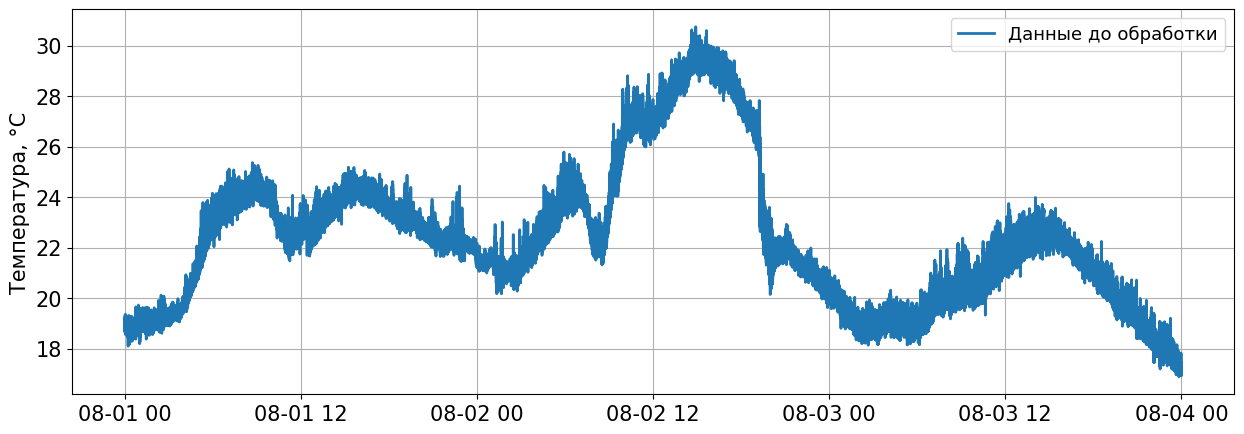

Данные до обработки


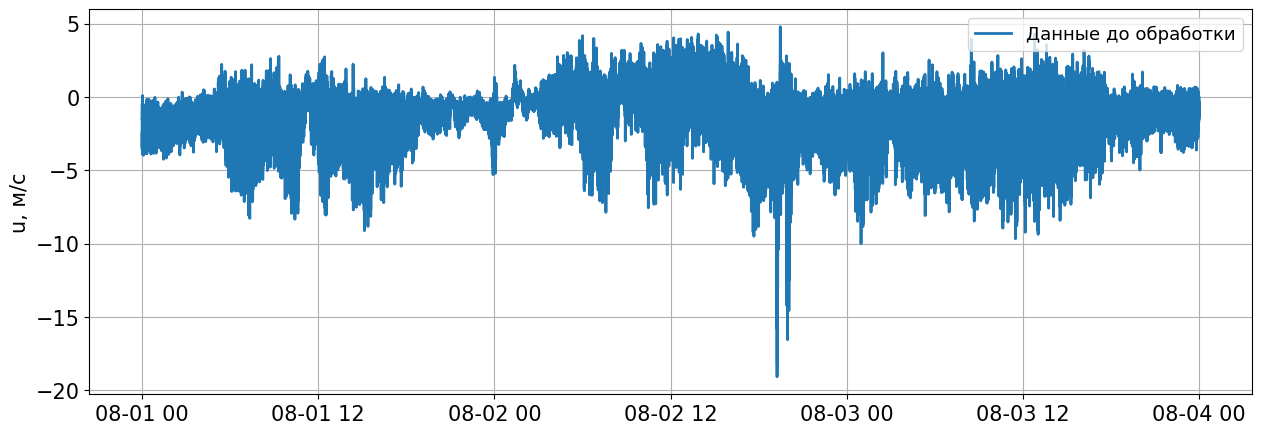

Данные до обработки


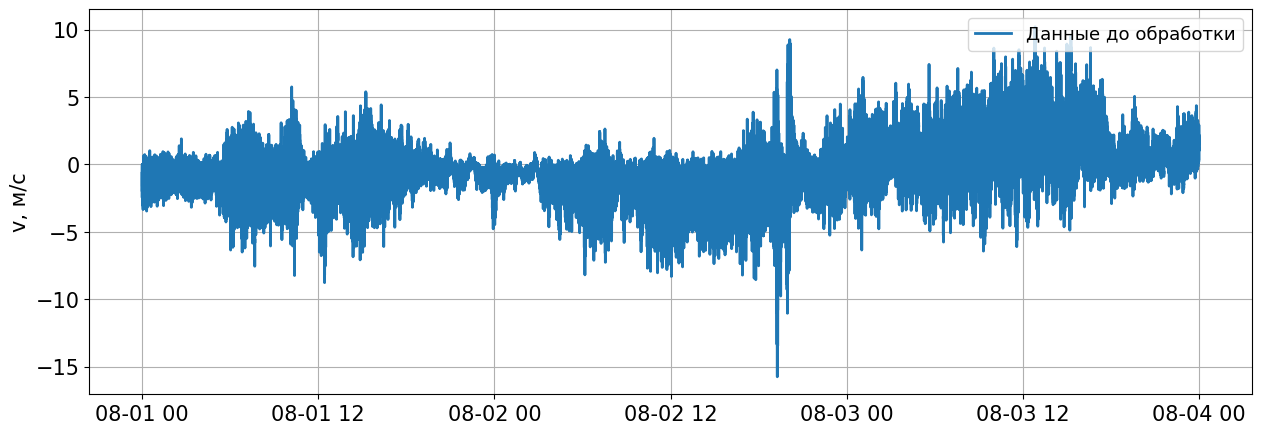

Данные до обработки


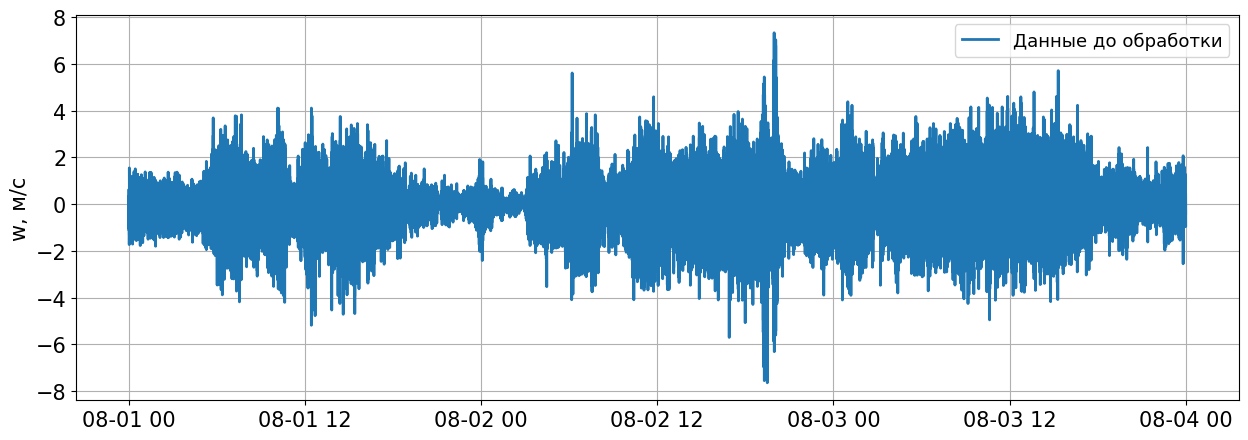

In [6]:
if plot:
    labels = 'Данные до обработки'
    dp.plot_timeseries(df.t, labels = labels, ylabel = 'Температура, °С', 
                       filename = f'{output_path}/plots/{start.date()}-{stop.date()}_t_input_data_{avg_period}min.png')
    dp.plot_timeseries(df.u, labels = labels, ylabel = 'u, м/с', 
                       filename = f'{output_path}/plots/{start.date()}-{stop.date()}_u_input_data_{avg_period}min.png')
    dp.plot_timeseries(df.v, labels = labels, ylabel = 'v, м/с', 
                       filename = f'{output_path}/plots/{start.date()}-{stop.date()}_v_input_data_{avg_period}min.png')
    dp.plot_timeseries(df.w, labels = labels, ylabel = 'w, м/с', 
                       filename = f'{output_path}/plots/{start.date()}-{stop.date()}_w_input_data_{avg_period}min.png')

# Обработка данных

## Разбиение данных на периоды осреднения

In [7]:
logger.info('Расчет интервалов осреднения')
df_bins = pp.create_bins(ser=df, step=step, start=start, stop=stop)

## Подсчет данных перед обработкой

In [8]:
counts_before_processing = dq.counts(df, df_bins)

## Фильтрация по абсолютным лимитам

In [9]:
logger.info('Фильтрация по абсолютным лимитам')
t = pp.absolute_limits_filtration(df.t, ulim=ulim_t, blim=blim_t, logger=logger)
u = pp.absolute_limits_filtration(df.u, ulim=ulim_u, blim=blim_u, logger=logger)
v = pp.absolute_limits_filtration(df.v, ulim=ulim_v, blim=blim_v, logger=logger)
w = pp.absolute_limits_filtration(df.w, ulim=ulim_w, blim=blim_w, logger=logger)


До фильтрации
После фильтрации


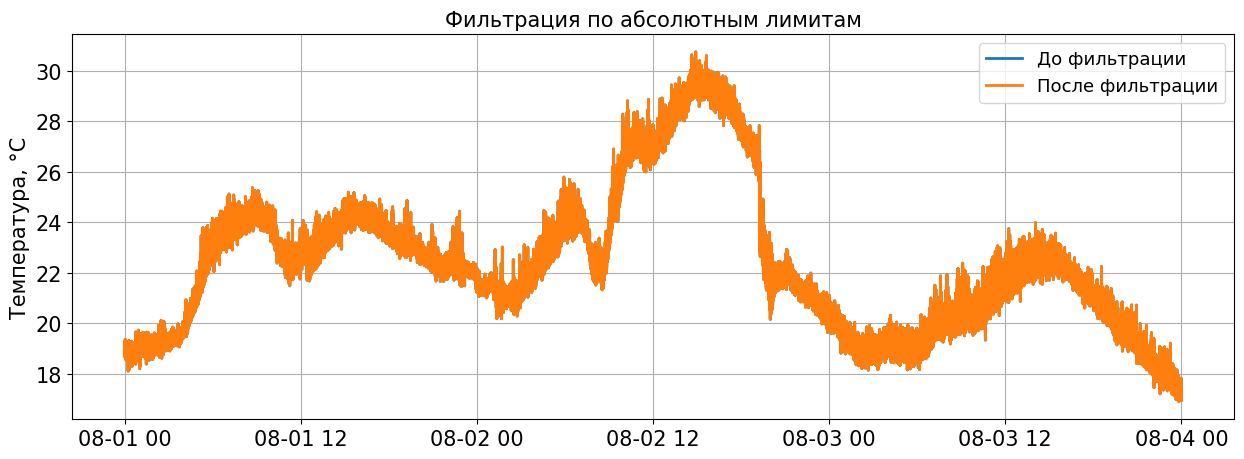

До фильтрации
После фильтрации


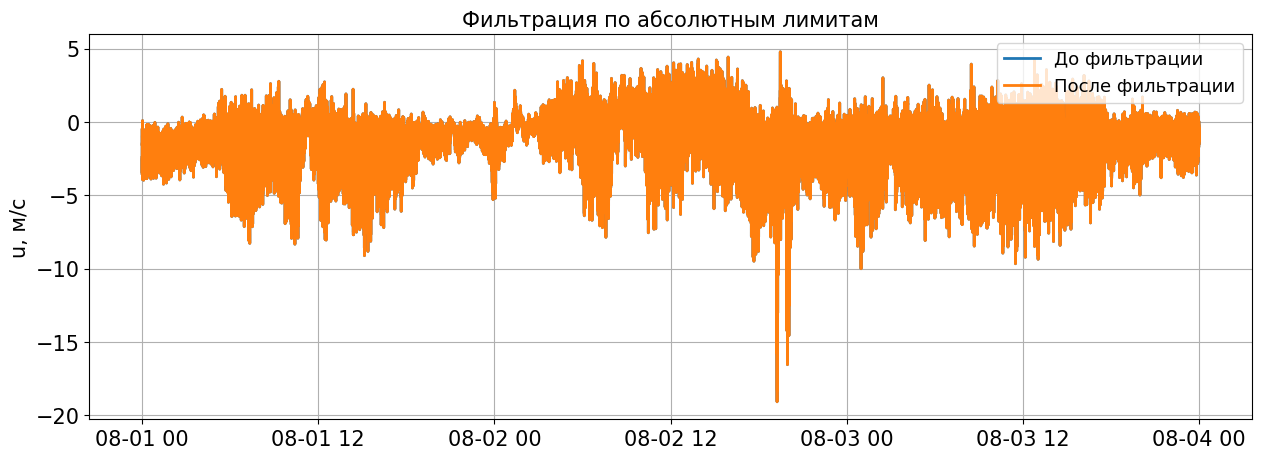

До фильтрации
После фильтрации


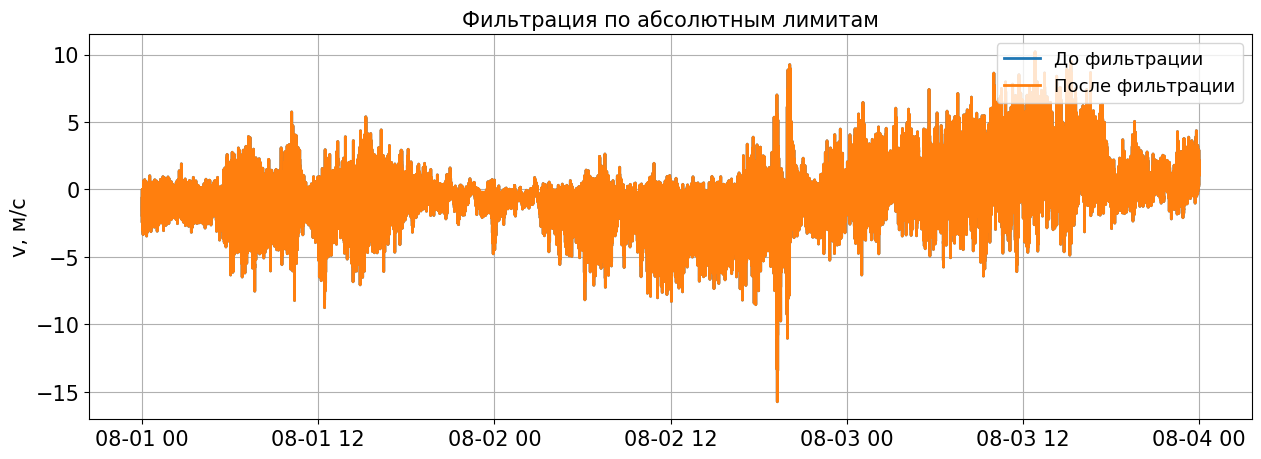

До фильтрации
После фильтрации


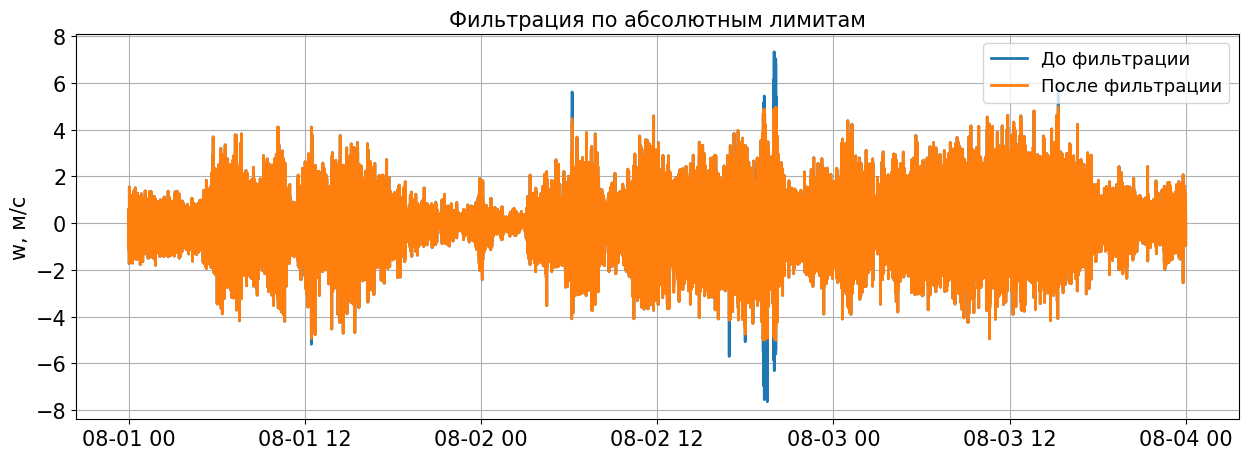

In [10]:
if plot:
    title = 'Фильтрация по абсолютным лимитам'
    labels = ['До фильтрации', 'После фильтрации']
    dp.plot_timeseries([df.t, t], labels = labels, title = title, ylabel = 'Температура, °С',
                       filename = f'{output_path}/plots/{start.date()}-{stop.date()}_t_absolute_limits_filtration_{avg_period}min.png')
    dp.plot_timeseries([df.u, u], labels = labels, title = title, ylabel = 'u, м/с', 
                       filename = f'{output_path}/plots/{start.date()}-{stop.date()}_u_absolute_limits_filtration_{avg_period}min.png')
    dp.plot_timeseries([df.v, v], labels = labels, title = title, ylabel = 'v, м/с', 
                       filename = f'{output_path}/plots/{start.date()}-{stop.date()}_v_absolute_limits_filtration_{avg_period}min.png')
    dp.plot_timeseries([df.w, w], labels = labels, title = title, ylabel = 'w, м/с',
                       filename = f'{output_path}/plots/{start.date()}-{stop.date()}_w_absolute_limits_filtration_{avg_period}min.png')


In [11]:
df1 = pd.DataFrame({
    't': t,
    'u': u,
    'v': v,
    'w': w
})

## Фильтрация "воротами"

In [12]:
logger.info("Фильтрация 'воротами'")
pp.gates_filtration(t, limit_t, df_bins, logger=logger, inplace=True)
pp.gates_filtration(u, limit_u, df_bins, logger=logger, inplace=True)
pp.gates_filtration(v, limit_v, df_bins, logger=logger, inplace=True)
pp.gates_filtration(w, limit_w, df_bins, logger=logger, inplace=True)

time
2021-08-01 00:00:00.028761088   -0.23
2021-08-01 00:00:00.078641920   -0.09
2021-08-01 00:00:00.128638208   -0.08
2021-08-01 00:00:00.178659840    0.04
2021-08-01 00:00:00.228627200   -0.21
                                 ... 
2021-08-03 23:59:59.704238848   -0.33
2021-08-03 23:59:59.753897472   -0.31
2021-08-03 23:59:59.803790592   -0.28
2021-08-03 23:59:59.853686784   -0.25
2021-08-03 23:59:59.903902720   -0.40
Name: w, Length: 5184082, dtype: float64

До фильтрации
После фильтрации


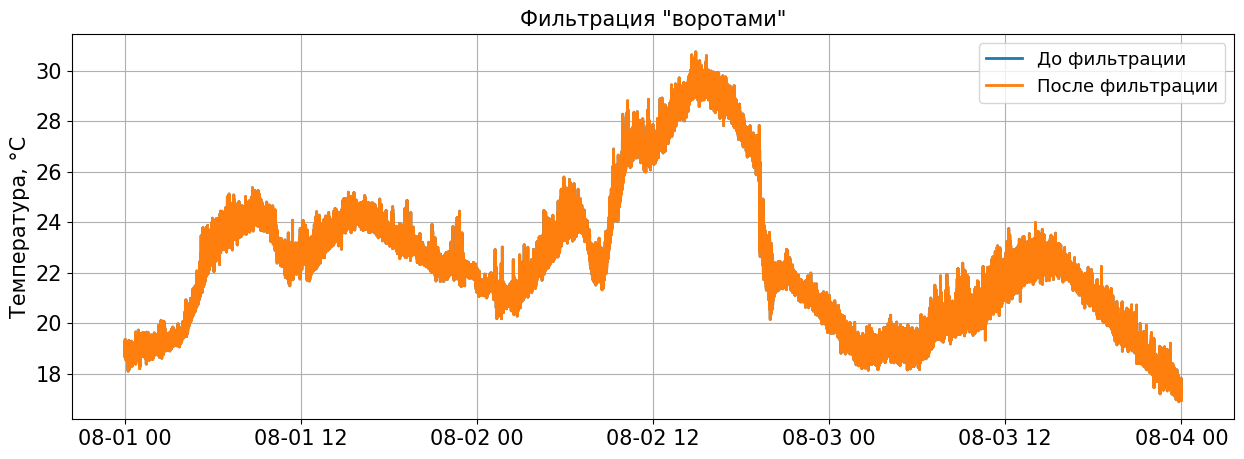

До фильтрации
После фильтрации


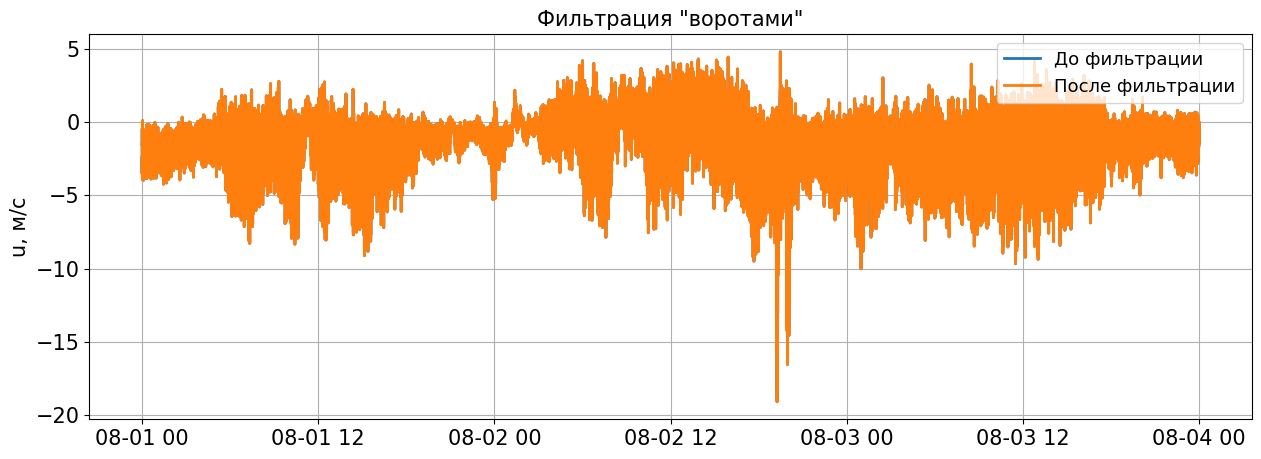

До фильтрации
После фильтрации


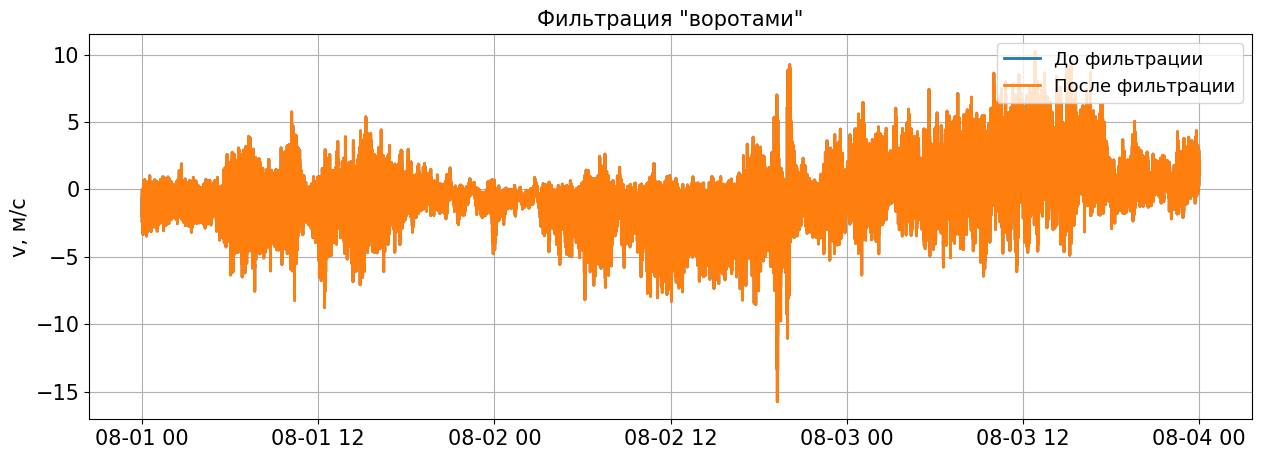

До фильтрации
После фильтрации


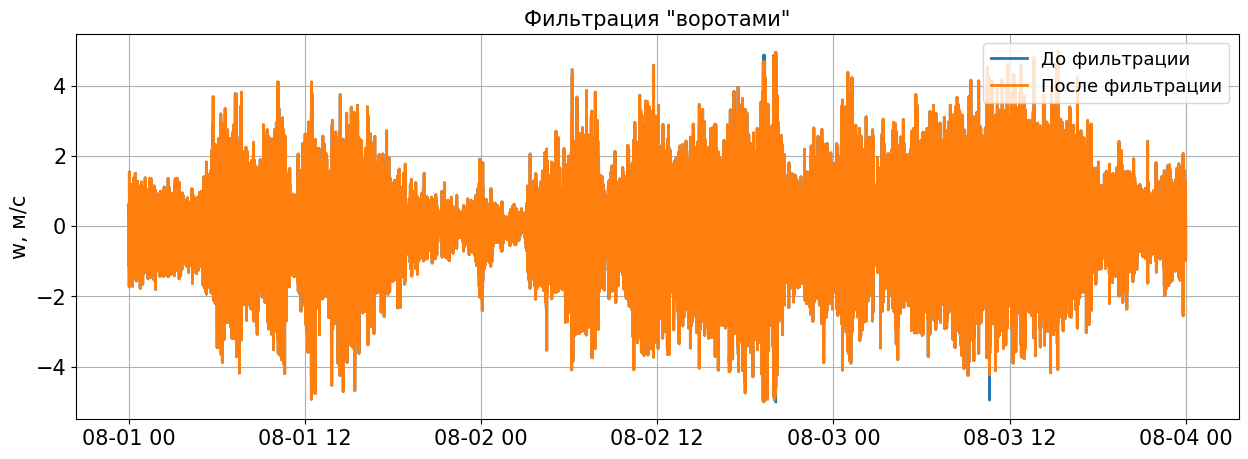

In [13]:
if plot:
    title = 'Фильтрация "воротами"'
    labels = ['До фильтрации', 'После фильтрации']
    dp.plot_timeseries([df1.t, t], labels = labels, title = title, ylabel = 'Температура, °С',
                       filename = f'{output_path}/plots/{start.date()}-{stop.date()}_t_gates_filtration_{avg_period}min.png')
    dp.plot_timeseries([df1.u, u], labels = labels, title = title, ylabel = 'u, м/с', 
                       filename = f'{output_path}/plots/{start.date()}-{stop.date()}_u_gates_filtration_{avg_period}min.png')
    dp.plot_timeseries([df1.v, v], labels = labels, title = title, ylabel = 'v, м/с', 
                       filename = f'{output_path}/plots/{start.date()}-{stop.date()}_v_gates_filtration_{avg_period}min.png')
    dp.plot_timeseries([df1.w, w], labels = labels, title = title, ylabel = 'w, м/с', 
                       filename = f'{output_path}/plots/{start.date()}-{stop.date()}_w_gates_filtration_{avg_period}min.png')

In [14]:
df1 = pd.DataFrame({
    't': t,
    'u': u,
    'v': v,
    'w': w
})

## Детрендинг

Данные до детрендинга
Тренды до детрендинга


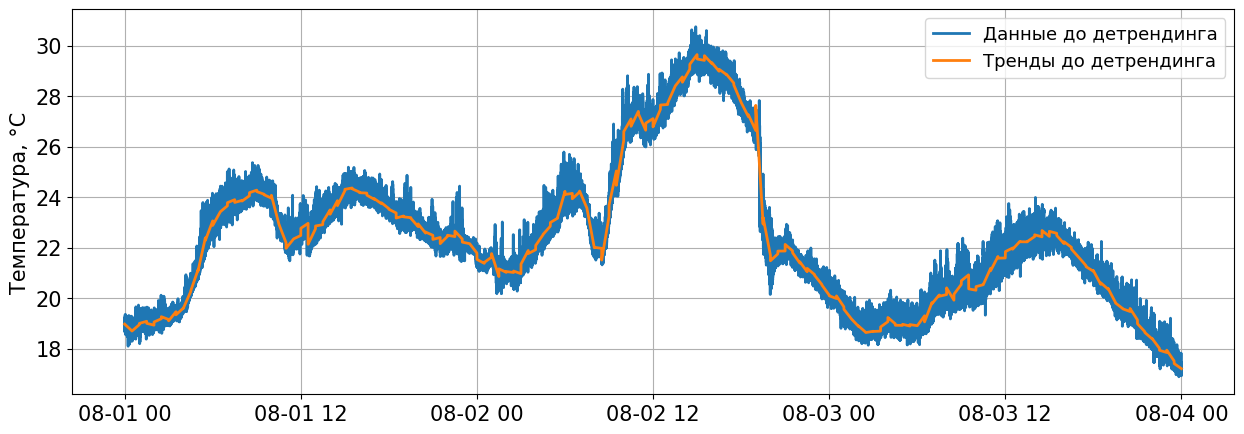

Данные до детрендинга
Тренды до детрендинга


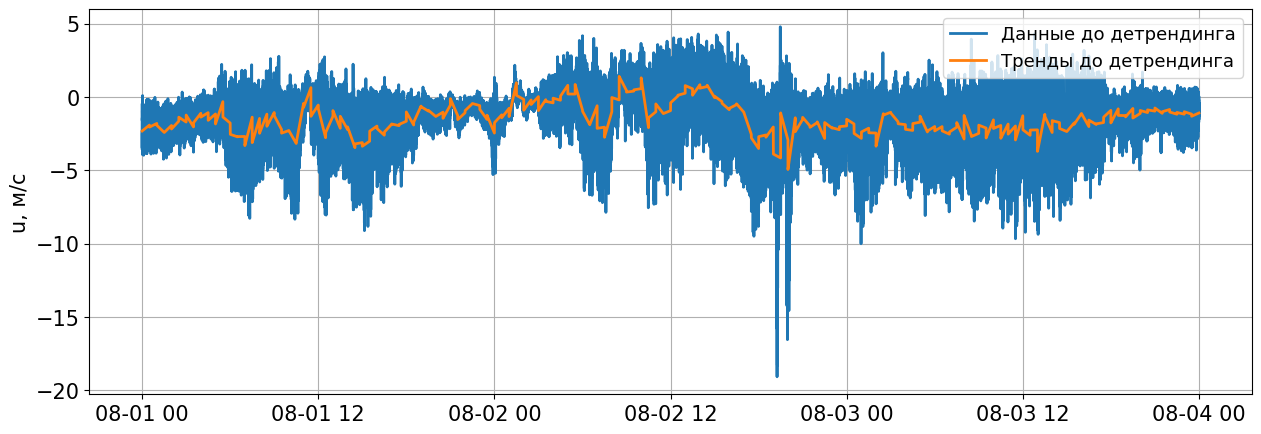

Данные до детрендинга
Тренды до детрендинга


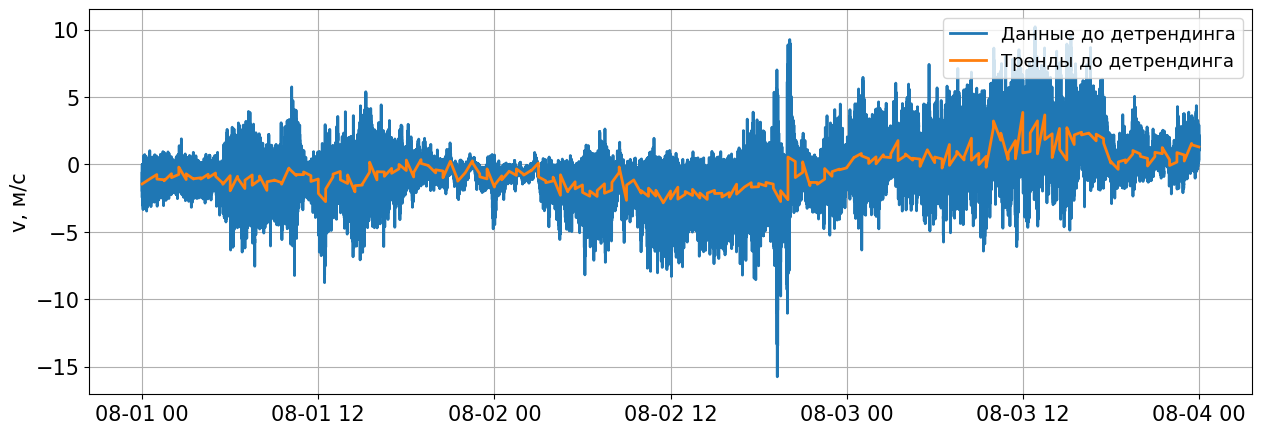

Данные до детрендинга
Тренды до детрендинга


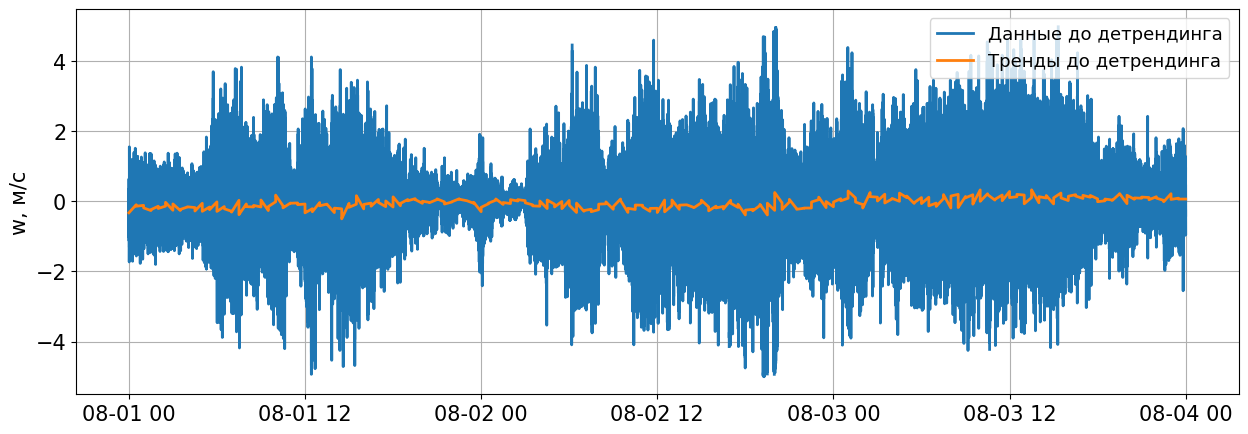

In [15]:
if plot:
    df1_trend = pp.detrend(df1, df_bins, mode = 'trend')
    labels = ['Данные до детрендинга', 'Тренды до детрендинга']
    dp.plot_timeseries([df1.t, df1_trend.t], labels = labels, ylabel = 'Температура, °С',
                       filename = f'{output_path}/plots/{start.date()}-{stop.date()}_t_before_detrending_{avg_period}min.png')
    dp.plot_timeseries([df1.u, df1_trend.u], labels = labels, ylabel = 'u, м/с',
                       filename = f'{output_path}/plots/{start.date()}-{stop.date()}_u_before_detrending_{avg_period}min.png')
    dp.plot_timeseries([df1.v, df1_trend.v], labels = labels, ylabel = 'v, м/с',
                       filename = f'{output_path}/plots/{start.date()}-{stop.date()}_v_before_detrending_{avg_period}min.png')
    dp.plot_timeseries([df1.w, df1_trend.w], labels = labels, ylabel = 'w, м/с',
                       filename = f'{output_path}/plots/{start.date()}-{stop.date()}_w_before_detrending_{avg_period}min.png')

In [16]:
pp.detrend(df1, df_bins=df_bins, mode='dwm', logger=logger, inplace=True)

t         u         v         w
time                                                                  
2021-08-01 00:00:00.028761088  18.796337 -2.227209 -1.727870 -0.114468
2021-08-01 00:00:00.078641920  18.806344 -2.297220 -1.717880  0.025526
2021-08-01 00:00:00.128638208  18.766351 -2.187231 -1.687891  0.035520
2021-08-01 00:00:00.178659840  18.786359 -2.357242 -1.587901  0.155513
2021-08-01 00:00:00.228627200  18.836365 -2.247254 -1.617911 -0.094493
...                                  ...       ...       ...       ...
2021-08-03 23:59:59.704238848  17.401737 -0.841430  2.030580 -0.330657
2021-08-03 23:59:59.753897472  17.391744 -0.791436  1.930585 -0.310657
2021-08-03 23:59:59.803790592  17.371750 -0.911442  1.850589 -0.280657
2021-08-03 23:59:59.853686784  17.351755 -0.751448  1.950594 -0.250658
2021-08-03 23:59:59.903902720  17.411760 -0.921454  1.940598 -0.400658

[5184082 rows x 4 columns]

Данные после детрендинга
Тренды после детрендинга


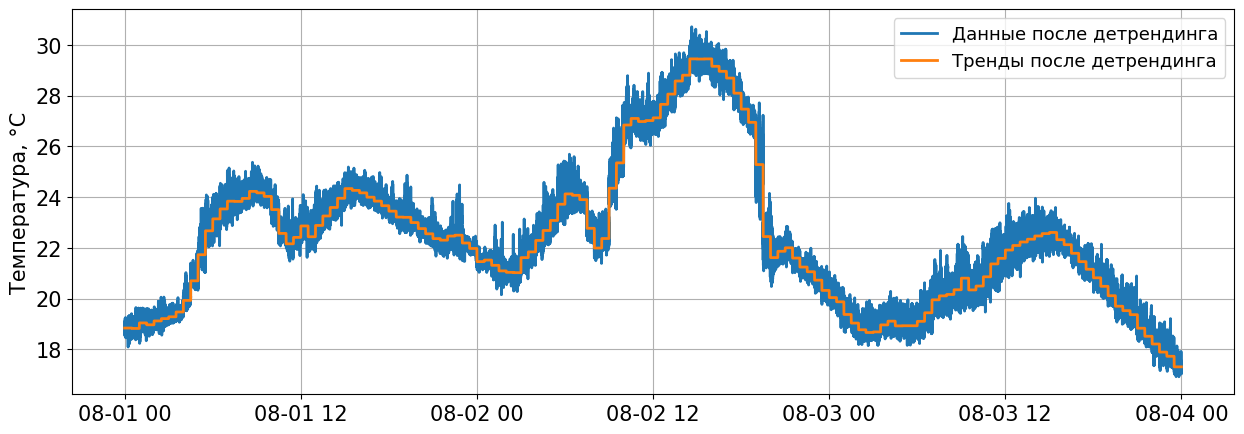

Данные после детрендинга
Тренды после детрендинга


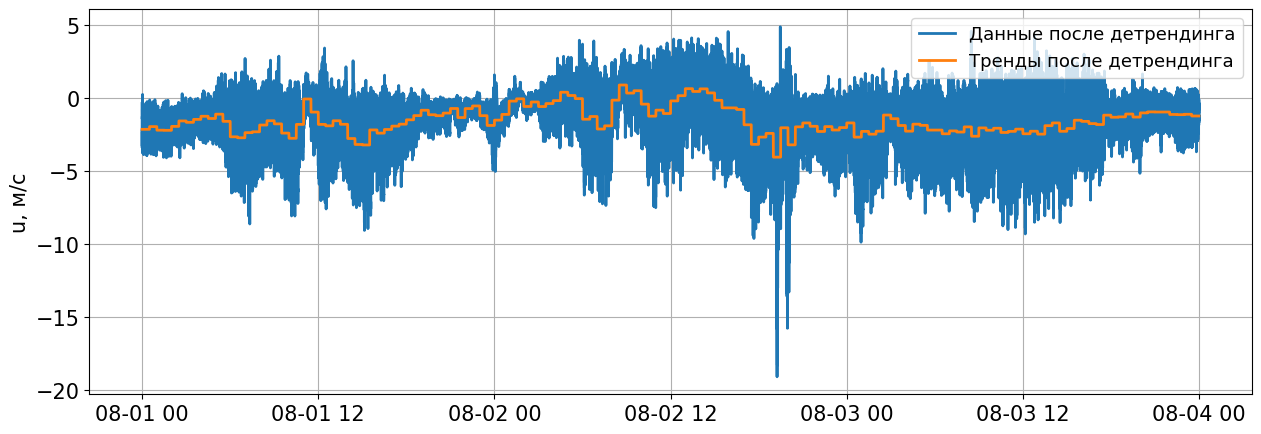

Данные после детрендинга
Тренды после детрендинга


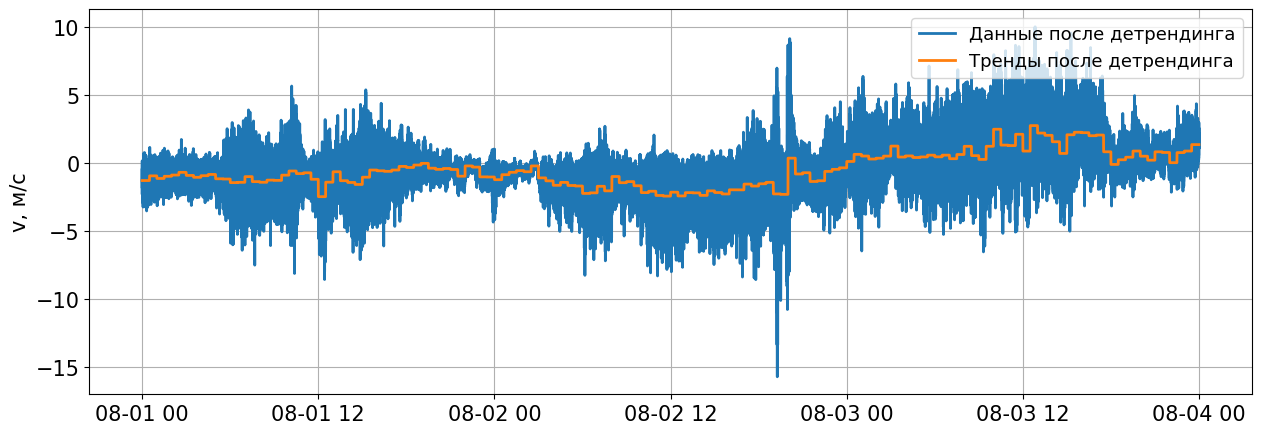

Данные после детрендинга
Тренды после детрендинга


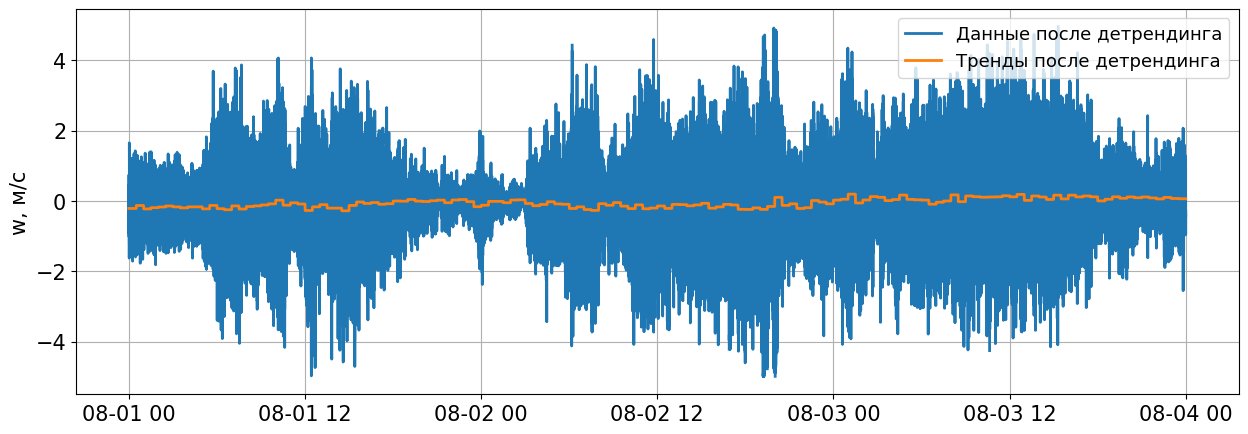

In [17]:
if plot:
    df1_trend = pp.detrend(df1, df_bins = df_bins, mode = 'trend')
    labels = ['Данные после детрендинга', 'Тренды после детрендинга']
    dp.plot_timeseries([df1.t, df1_trend.t], labels = labels, ylabel = 'Температура, °С',
                       filename = f'{output_path}/plots/{start.date()}-{stop.date()}_t_after_detrending_{avg_period}min.png')
    dp.plot_timeseries([df1.u, df1_trend.u], labels = labels, ylabel = 'u, м/с',
                       filename = f'{output_path}/plots/{start.date()}-{stop.date()}_u_after_detrending_{avg_period}min.png')
    dp.plot_timeseries([df1.v, df1_trend.v], labels = labels, ylabel = 'v, м/с',
                       filename = f'{output_path}/plots/{start.date()}-{stop.date()}_v_after_detrending_{avg_period}min.png')
    dp.plot_timeseries([df1.w, df1_trend.w], labels = labels, ylabel = 'w, м/с',
                       filename = f'{output_path}/plots/{start.date()}-{stop.date()}_w_after_detrending_{avg_period}min.png')
    

## Фильтрация сигмами

In [18]:
t = pp.sigmas_filtration(df1.t, nsig=nsig, n=n, iterations=iterations, df_bins=df_bins, logger=logger)
u = pp.sigmas_filtration(df1.u, nsig=nsig, n=n, iterations=iterations, df_bins=df_bins, logger=logger)
v = pp.sigmas_filtration(df1.v, nsig=nsig, n=n, iterations=iterations, df_bins=df_bins, logger=logger)
w = pp.sigmas_filtration(df1.w, nsig=nsig_w, n=n, iterations=iterations, df_bins=df_bins, logger=logger)

До фильтрации
После фильтрации


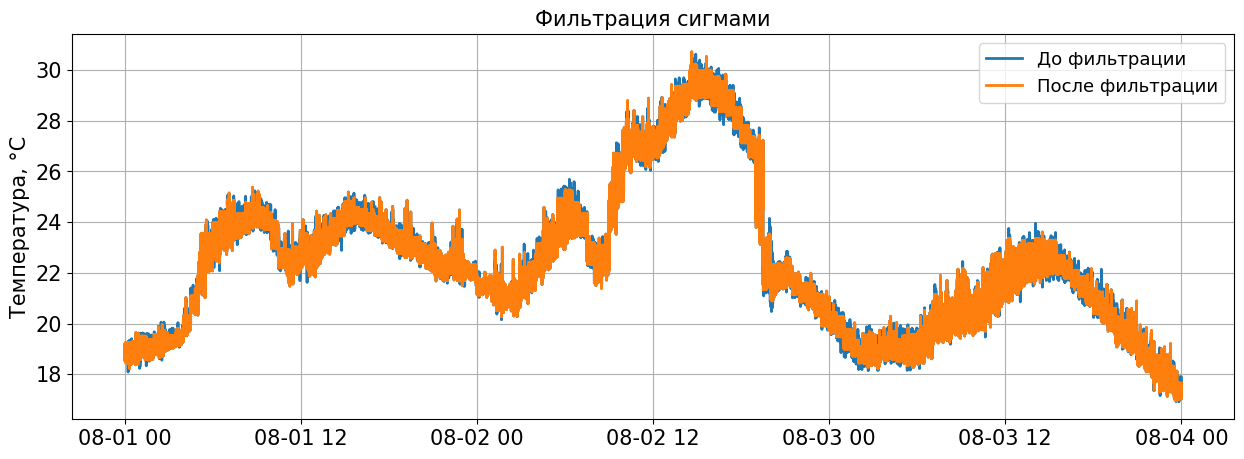

До фильтрации
После фильтрации


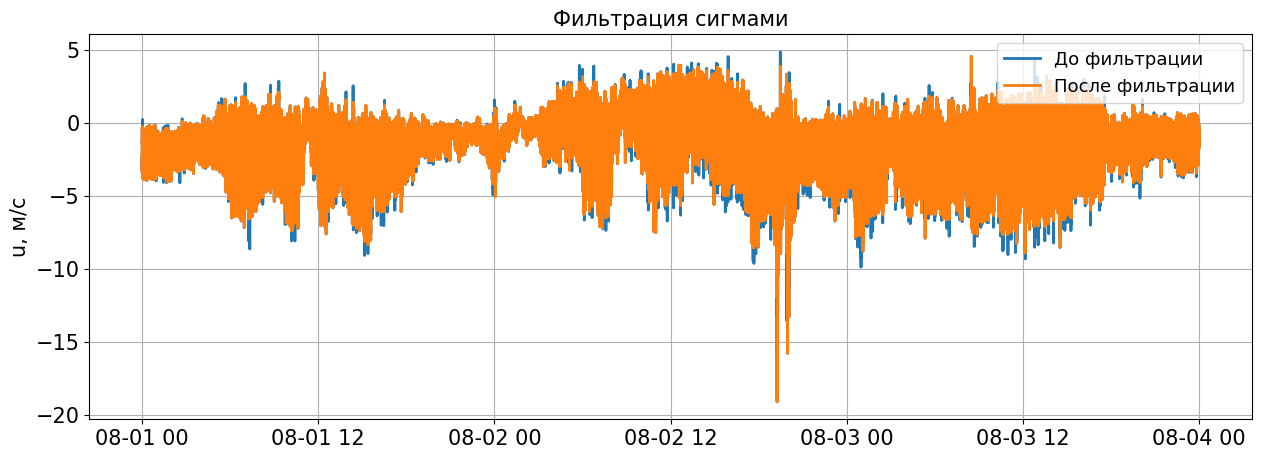

До фильтрации
После фильтрации


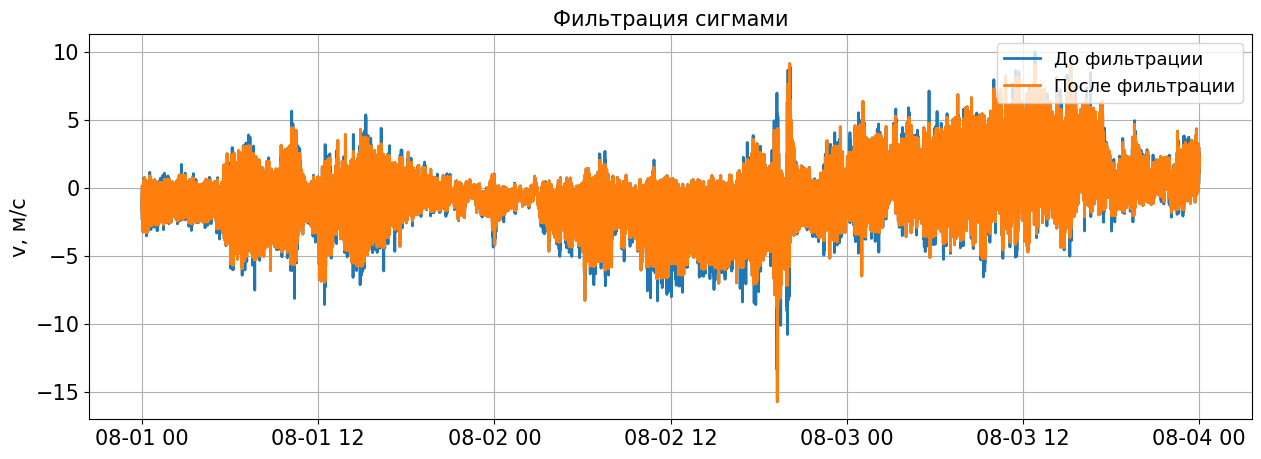

До фильтрации
После фильтрации


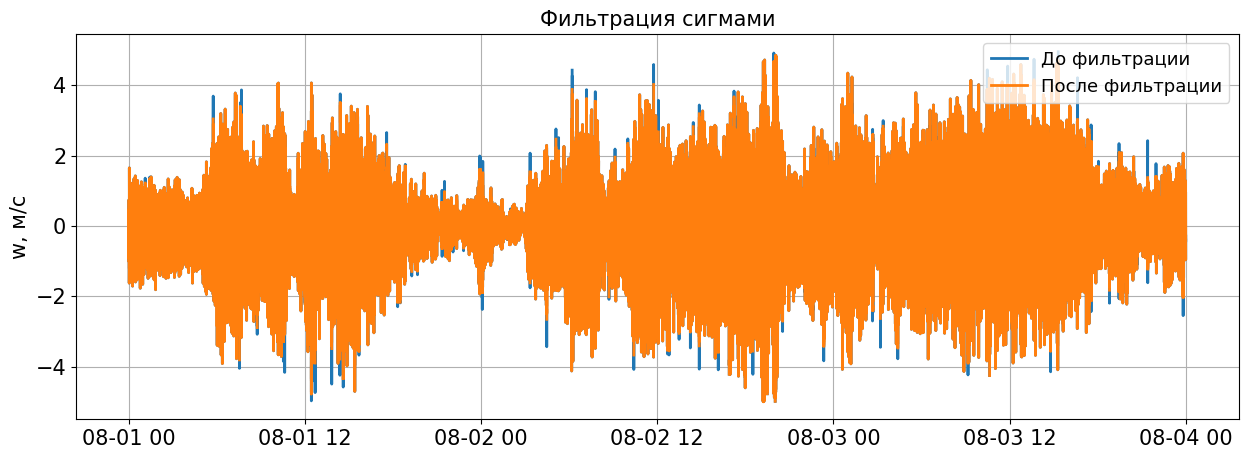

In [19]:
if plot:
    title = 'Фильтрация сигмами'
    labels = ['До фильтрации', 'После фильтрации']
    dp.plot_timeseries([df1.t, t], labels = labels, ylabel = 'Температура, °С', title = title,
                       filename = f'{output_path}/plots/{start.date()}-{stop.date()}_t_sigmas_filtration_{avg_period}min.png')
    dp.plot_timeseries([df1.u, u], labels = labels, ylabel = 'u, м/с', title = title,
                       filename = f'{output_path}/plots/{start.date()}-{stop.date()}_u_sigmas_filtration_{avg_period}min.png')
    dp.plot_timeseries([df1.v, v], labels = labels, ylabel='v, м/с', title = title,
                       filename = f'{output_path}/plots/{start.date()}-{stop.date()}_v_sigmas_filtration_{avg_period}min.png')
    dp.plot_timeseries([df1.w, w], labels = labels, ylabel='w, м/с', title = title,
                       filename = f'{output_path}/plots/{start.date()}-{stop.date()}_w_sigmas_filtration_{avg_period}min.png')

In [20]:
df1 = pd.DataFrame({
    't': t,
    'u': u,
    'v': v,
    'w': w
})

## Заполнение пропусков

In [21]:
counts_before_gapfilling = dq.counts(df1, df_bins)

In [22]:
pp.fillgaps(df1, inplace=True)

In [23]:
counts_after_gapfilling = dq.counts(df1, df_bins)

## Расчет угла атаки

In [24]:
bad_angles_counts, angles = dq.angle_of_attack_counts(df1, df_bins, minaa=minaa, maxaa=maxaa)
angles_means = ec.means(angles, df_bins)

## Поворот осей координат

In [25]:
df1_rot, angles_of_rotations = pp.axis_rotations(df1, D, df_bins, logger=logger, inplace=False)

## Расчет средних значений

In [26]:
df1_means = ec.means(df1, df_bins)
df1_rot_means = ec.means(df1_rot, df_bins)

Данные до поворота
Данные после поворота
Средние до поворота
Средние после поворота


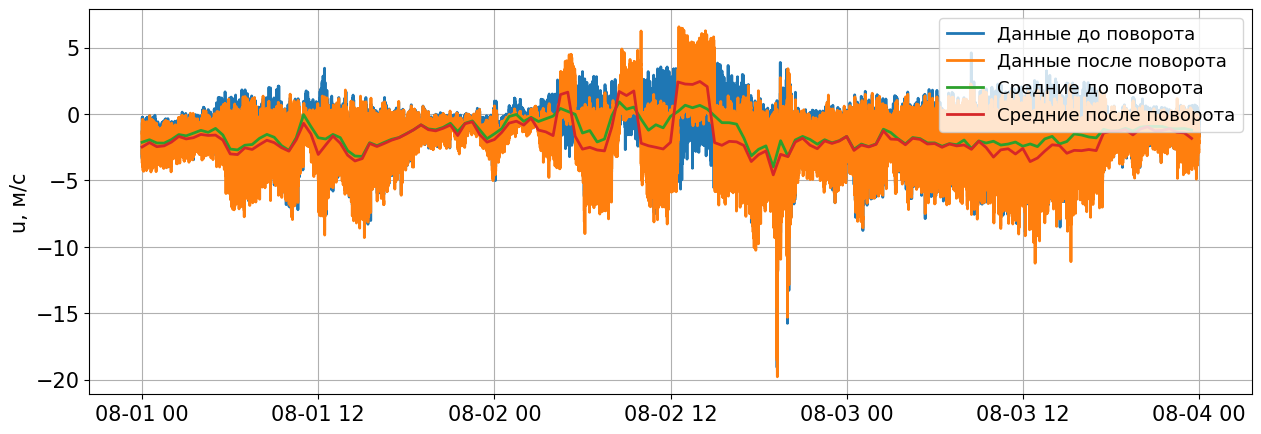

Данные до поворота
Данные после поворота
Средние до поворота
Средние после поворота


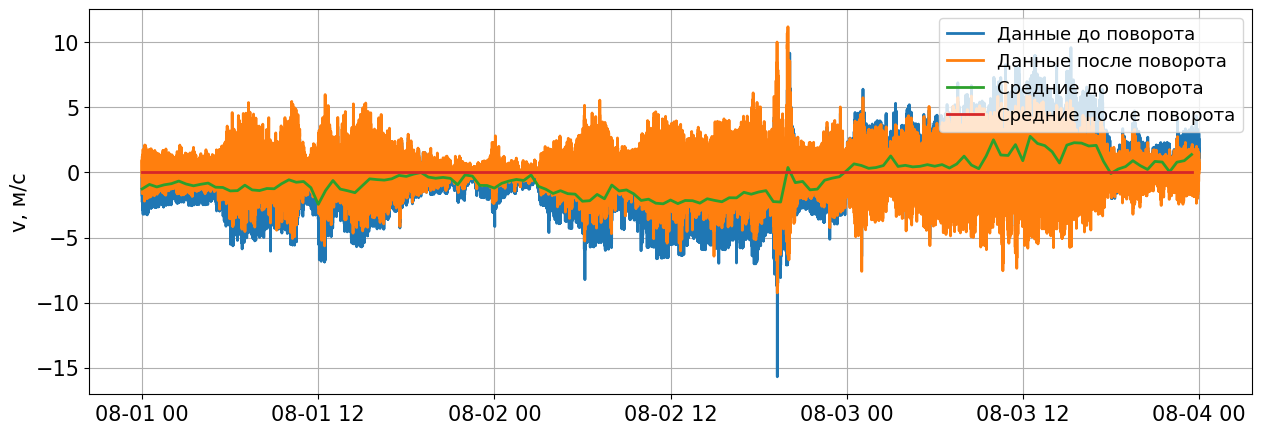

Данные до поворота
Данные после поворота
Средние до поворота
Средние после поворота


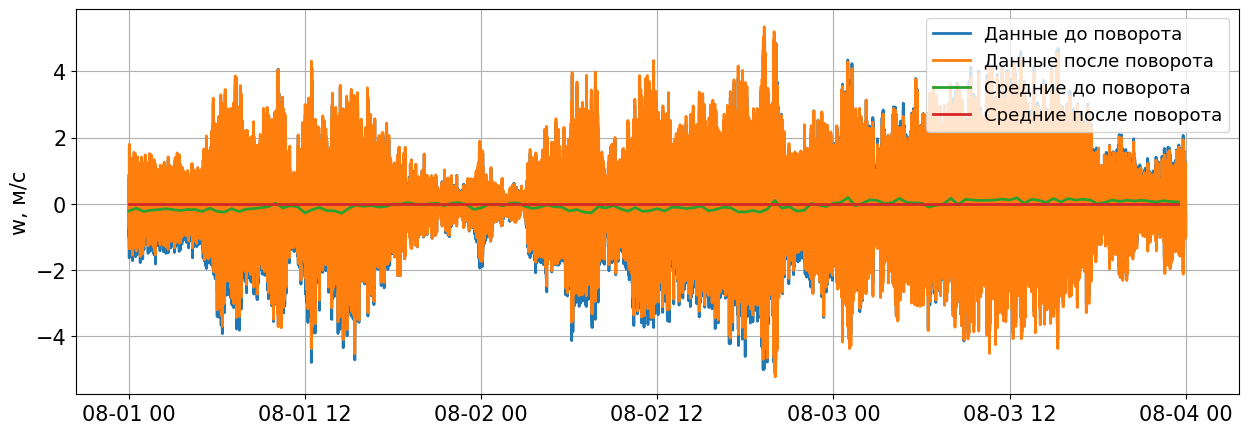

In [27]:
if plot:
    labels = ['Данные до поворота','Данные после поворота','Средние до поворота','Средние после поворота']
    dp.plot_timeseries([df1.u, df1_rot.u, df1_means.u, df1_rot_means.u], labels = labels, ylabel = 'u, м/с',
                       filename = f'{output_path}/plots/{start.date()}-{stop.date()}_u_axis_rotations_{avg_period}min.png')
    dp.plot_timeseries([df1.v, df1_rot.v, df1_means.v, df1_rot_means.v], labels = labels, ylabel = 'v, м/с',
                       filename = f'{output_path}/plots/{start.date()}-{stop.date()}_v_axis_rotations_{avg_period}min.png')
    dp.plot_timeseries([df1.w, df1_rot.w, df1_means.w, df1_rot_means.w], labels = labels, ylabel = 'w, м/с',
                       filename = f'{output_path}/plots/{start.date()}-{stop.date()}_w_axis_rotations_{avg_period}min.png')

## Оценка качетсва 

Index(['t', 'u', 'v', 'w'], dtype='object')


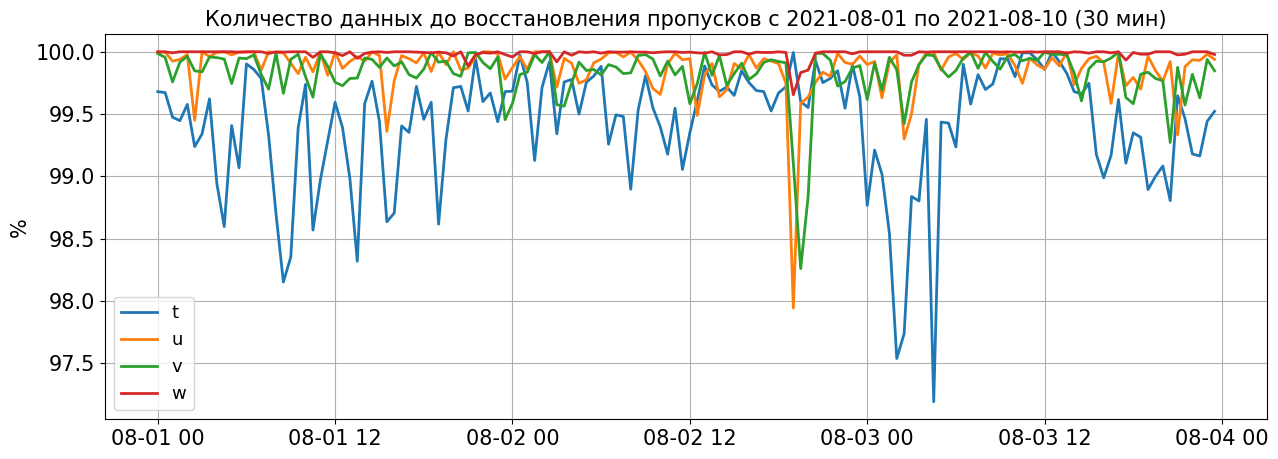

In [29]:
data_availability = counts_before_gapfilling / counts_before_processing * 100
data_availability_flags = data_availability < min_data_availability
if plot:
    title = f'Количество данных до восстановления пропусков с {start.date()} по {stop.date()} ({avg_period} мин)'
    dp.plot_timeseries(data_availability, labels = data_availability.columns, title = title, loc = 'lower left', ylabel = '%',
                       filename = f'{output_path}/quality/{start.date()}-{stop.date()}_counts_before_gapfilling_{avg_period}min.png')

None
uhl


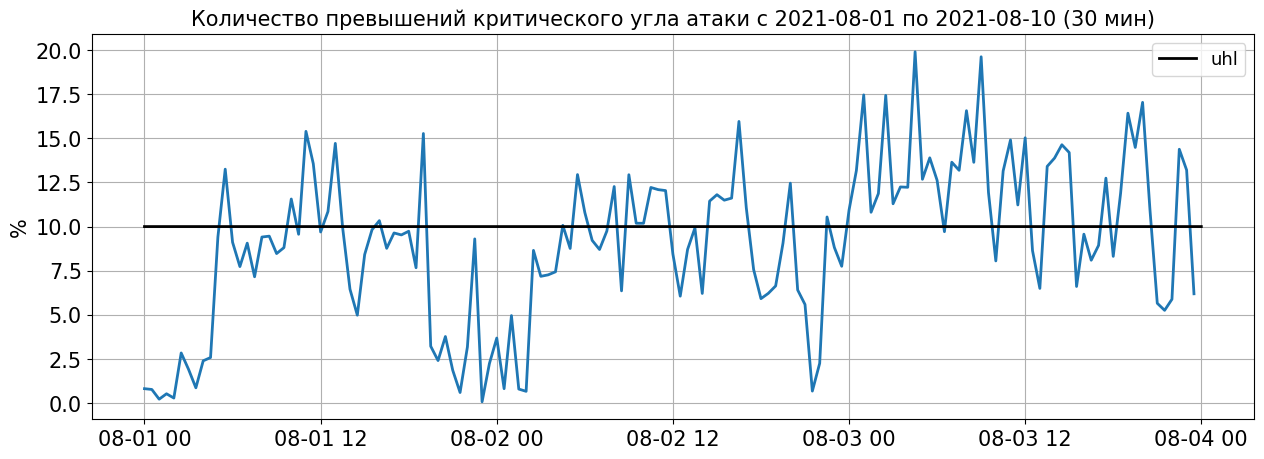

None
avg
uhl
bhl


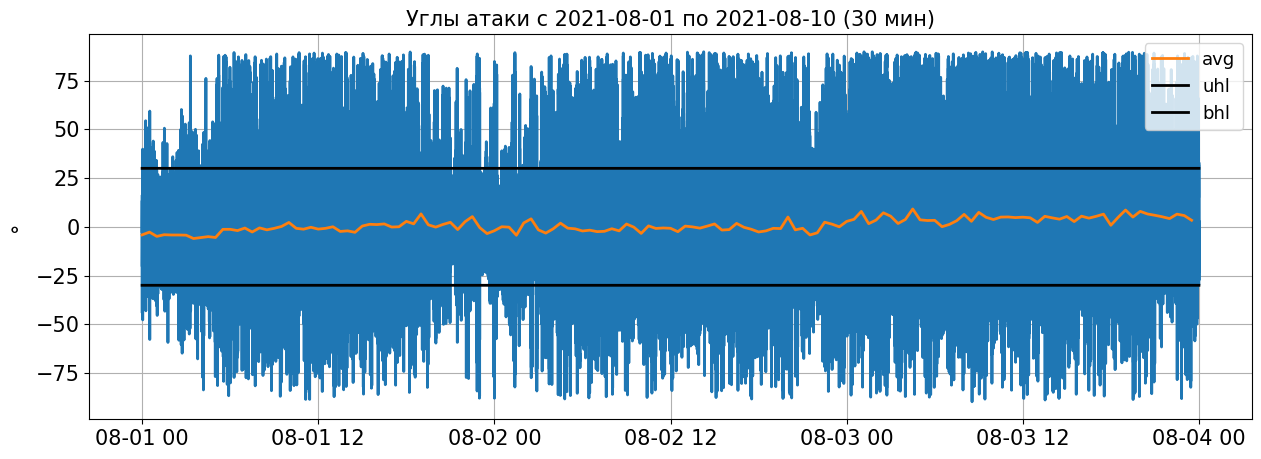

In [30]:
bad_angles_percent = bad_angles_counts / counts_after_gapfilling.u * 100
bad_angles_flags = bad_angles_percent > aaoo

if plot:
    uhl = pd.Series(aaoo, index = angles.index)
    clrs = [None, 'k']
    title=f'Количество превышений критического угла атаки с {start.date()} по {stop.date()} ({avg_period} мин)'
    dp.plot_timeseries([bad_angles_percent, uhl], labels = [None,'uhl'], clrs = clrs, ylabel = '%', title = title,
                       filename = f'{output_path}/quality/plots/{start.date()}-{stop.date()}_bad_angles_counts_{avg_period}min.png')
    
    uhl = pd.Series(maxaa, index = angles.index)
    bhl = pd.Series(minaa, index = angles.index)
    clrs = [None, None, 'k', 'k']
    labels = [None, 'avg', 'uhl', 'bhl']
    title = f'Углы атаки с {start.date()} по {stop.date()} ({avg_period} мин)'
    dp.plot_timeseries([angles, angles_means, uhl, bhl], labels = labels, clrs = clrs, title = title, ylabel = '°',
                       filename = f'{output_path}/quality/plots/{start.date()}-{stop.date()}_angles_of_atack_{avg_period}min.png')


Index(['t', 'u', 'v', 'w'], dtype='object')
hl
None
sl
None


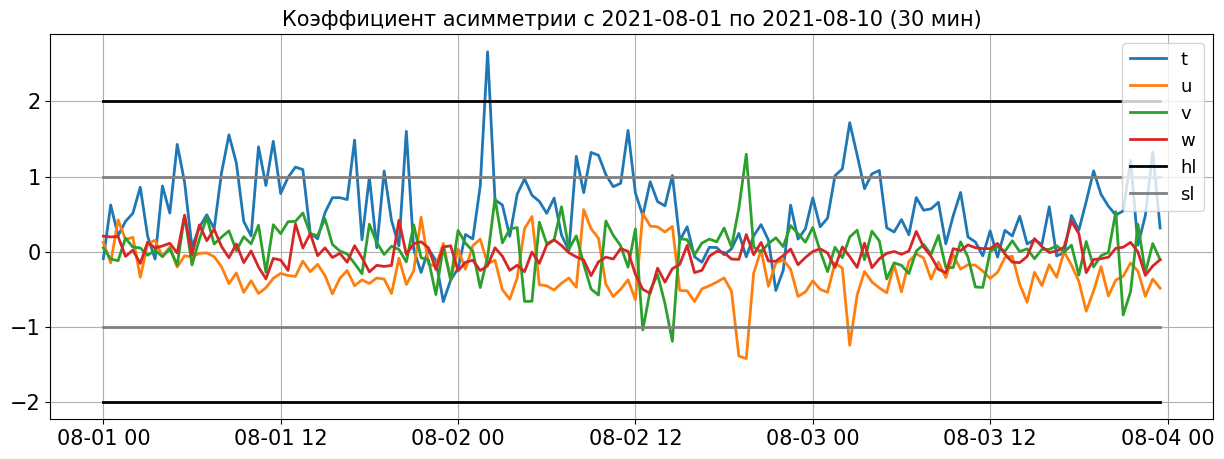

In [31]:
skew = dq.skewness(df1_rot, df_bins)
skew_flags = (skew < bhl_sk) | (skew > uhl_sk)

if plot:
    uhl = pd.Series(uhl_sk, index = skew.index)
    bhl = pd.Series(bhl_sk, index = skew.index)
    usl = pd.Series(usl_sk, index = skew.index)
    bsl = pd.Series(bsl_sk, index = skew.index)
    
    title = f'Коэффициент асимметрии с {start.date()} по {stop.date()} ({avg_period} мин)'
    clrs = [ None, 'k', 'k', 'gray', 'gray']
    labels = [skew.columns, 'hl', None, 'sl', None]
    dp.plot_timeseries([skew, uhl, bhl, usl, bsl], labels = labels, clrs = clrs, title = title,
                       filename = f'{output_path}/quality/plots/{start.date()}-{stop.date()}_skewness_{avg_period}min.png')

Index(['t', 'u', 'v', 'w'], dtype='object')
uhl
usl


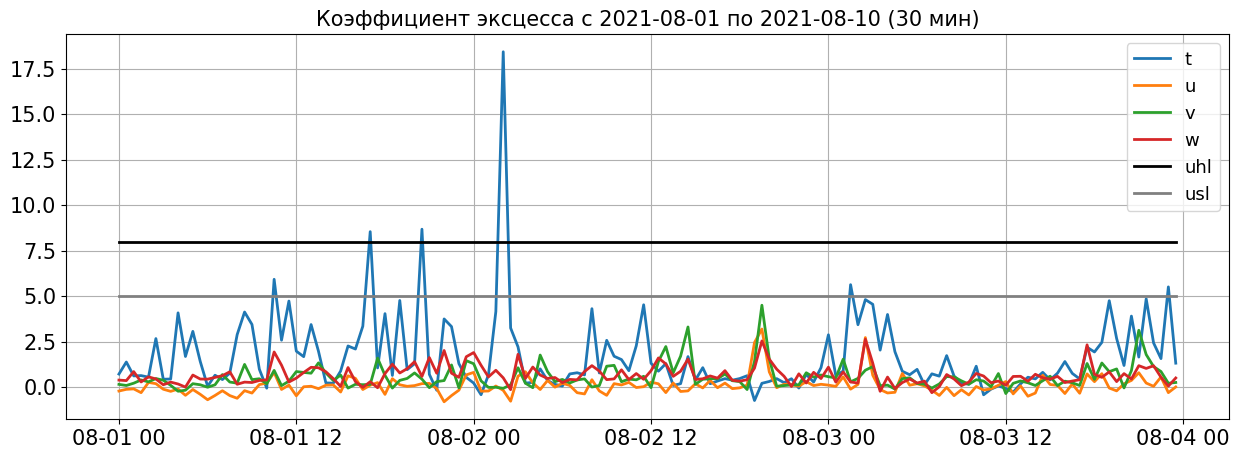

In [32]:
kurt = dq.kurtosis(df1_rot, df_bins)
kurt_flags = kurt > uhl_kr

if plot:
    uhl = pd.Series(uhl_kr, index=kurt.index)
    # bhl = pd.Series(bhl_kr, index=kurt.index)
    usl = pd.Series(usl_kr, index=kurt.index)
    # bsl = pd.Series(bsl_kr, index=kurt.index) 
    
    title = f'Коэффициент эксцесса с {start.date()} по {stop.date()} ({avg_period} мин)'
    clrs = [None, 'k', 'gray']
    labels = [kurt.columns, 'uhl', 'usl']
    dp.plot_timeseries([kurt, uhl, usl], clrs = clrs, labels = labels, title = title,
                       filename = f'{output_path}/quality/plots/{start.date()}-{stop.date()}_kurtosis_{avg_period}min.png')

Index(['t', 'u', 'v', 'w'], dtype='object')


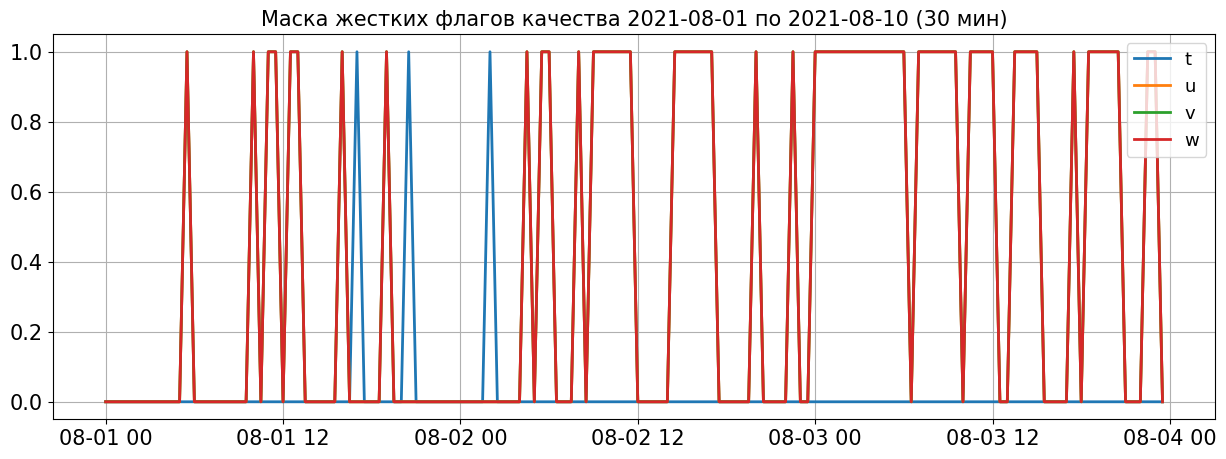

In [36]:
hard_flags = (data_availability_flags + skew_flags + kurt_flags)
hard_flags[['u','v','w']] = hard_flags[['u','v','w']].add(bad_angles_flags, axis=0)

if plot:
    title = f'Маска жестких флагов качества {start.date()} по {stop.date()} ({avg_period} мин)'
    dp.plot_timeseries(hard_flags, labels=hard_flags.columns, title = title,
                       filename = f'{output_path}/quality/plots/{start.date()}-{stop.date()}_hard_flags_{avg_period}min.png')

In [37]:
counts_before_processing.to_csv(f'{output_path}/quality/{start.date()}-{stop.date()}_counts_before_processing_{avg_period}min.csv')
counts_before_gapfilling.to_csv(f'{output_path}/quality/{start.date()}-{stop.date()}_counts_before_gapfilling_{avg_period}min.csv')
counts_after_gapfilling.to_csv(f'{output_path}/quality/{start.date()}-{stop.date()}_counts_after_gapfilling_{avg_period}min.csv')
bad_angles_counts.to_csv(f'{output_path}/quality/{start.date()}-{stop.date()}_bad_angles_counts_{avg_period}min.csv')
skew.to_csv(f'{output_path}/quality/{start.date()}-{stop.date()}_skewness_{avg_period}min.csv')
kurt.to_csv(f'{output_path}/quality/{start.date()}-{stop.date()}_kurtosis_{avg_period}min.csv')
angles_of_rotations.to_csv(f'{output_path}/quality/{start.date()}-{stop.date()}_angles_of_rotations_{avg_period}min.csv')
hard_flags.to_csv(f'{output_path}/quality/{start.date()}-{stop.date()}_hard_flags_{avg_period}min.csv')

## Расчет пульсаций и моментов

In [38]:
ec.pulsations(df1_rot, df_bins=df_bins, inplace=True)

t         u         v         w
time                                                                 
2021-08-01 00:00:00.028761088 -0.046257 -0.316099 -0.344951  0.127289
2021-08-01 00:00:00.078641920 -0.036249 -0.358858 -0.300545  0.271509
2021-08-01 00:00:00.128638208 -0.076243 -0.248561 -0.331057  0.271990
2021-08-01 00:00:00.178659840 -0.056235 -0.332764 -0.158157  0.399723
2021-08-01 00:00:00.228627200 -0.006228 -0.275480 -0.240220  0.143822
...                                 ...       ...       ...       ...
2021-08-03 23:59:59.704238848  0.089208 -0.234135  0.705936 -0.400599
2021-08-03 23:59:59.753897472  0.079215 -0.126722  0.677607 -0.376967
2021-08-03 23:59:59.803790592  0.059220 -0.146684  0.534635 -0.347623
2021-08-03 23:59:59.853686784  0.039225 -0.117434  0.720866 -0.316620
2021-08-03 23:59:59.903902720  0.099231 -0.216880  0.586443 -0.470058

[5184082 rows x 4 columns]

In [39]:
df1_rot_means['uu']     = ec.stat_moments(df1_rot[['u']*2], df_bins)
df1_rot_means['vv']     = ec.stat_moments(df1_rot[['v']*2], df_bins)
df1_rot_means['ww']     = ec.stat_moments(df1_rot[['w']*2], df_bins)
df1_rot_means['tt']     = ec.stat_moments(df1_rot[['t']*2], df_bins)
df1_rot_means['wu']     = ec.stat_moments(df1_rot[['w','u']], df_bins)
df1_rot_means['wv']     = ec.stat_moments(df1_rot[['w','v']], df_bins)
df1_rot_means['wt']     = ec.stat_moments(df1_rot[['w','t']], df_bins)
df1_rot_means['wu_h']   = (df1_rot_means.wu ** 2 + df1_rot_means.wv ** 2) ** 0.5
df1_rot_means['u_star'] = df1_rot_means.wu_h ** 0.5
df1_rot_means['L']      = -(df1_rot_means.t + 273.15) * df1_rot_means.u_star ** 3 / ( 9.8 * 0.4 * df1_rot_means.wt) 
df1_rot_means['zeta']   = z / df1_rot_means.L
df1_rot_means['TKE']    = (df1_rot_means.uu + df1_rot_means.vv + df1_rot_means.ww) / 2
df1_rot_means['A']      = df1_rot_means.ww / (df1_rot_means.uu + df1_rot_means.vv + df1_rot_means.ww)
df1_rot_means['wuu']    = ec.stat_moments(df1_rot[['w','u','u']], df_bins)
df1_rot_means['wvv']    = ec.stat_moments(df1_rot[['w','v','v']], df_bins)
df1_rot_means['wtt']    = ec.stat_moments(df1_rot[['w','t','t']], df_bins)
df1_rot_means['wwt']    = ec.stat_moments(df1_rot[['w','w','t']], df_bins)
df1_rot_means['uuu']    = ec.stat_moments(df1_rot[['u']*3], df_bins)
df1_rot_means['vvv']    = ec.stat_moments(df1_rot[['v']*3], df_bins)
df1_rot_means['www']    = ec.stat_moments(df1_rot[['w']*3], df_bins)
df1_rot_means['ttt']    = ec.stat_moments(df1_rot[['t']*3], df_bins)

df1_rot_means.to_csv(f'{output_path}/output/{start.date()}-{stop.date()}_moments_{avg_period}min.csv')

None


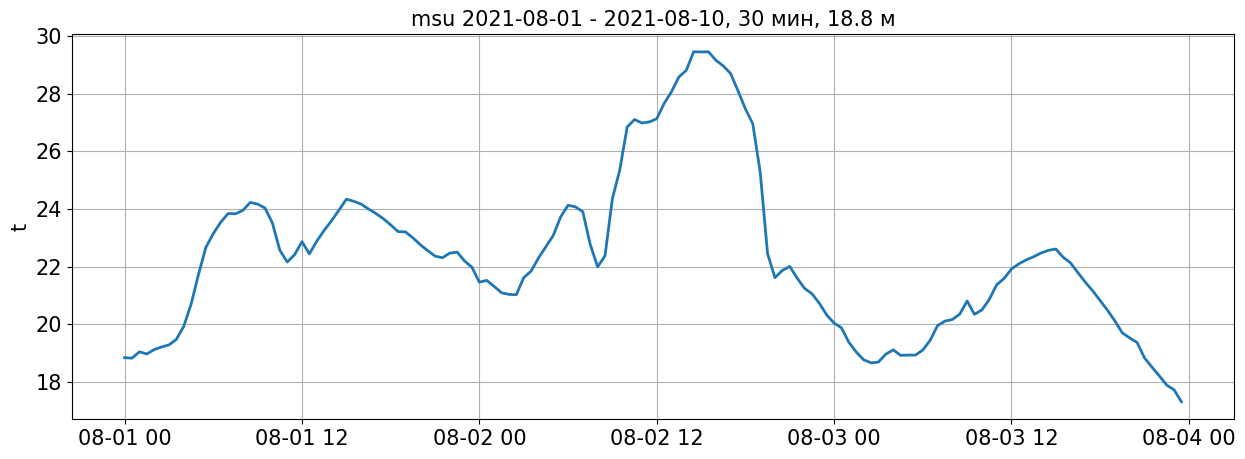

None


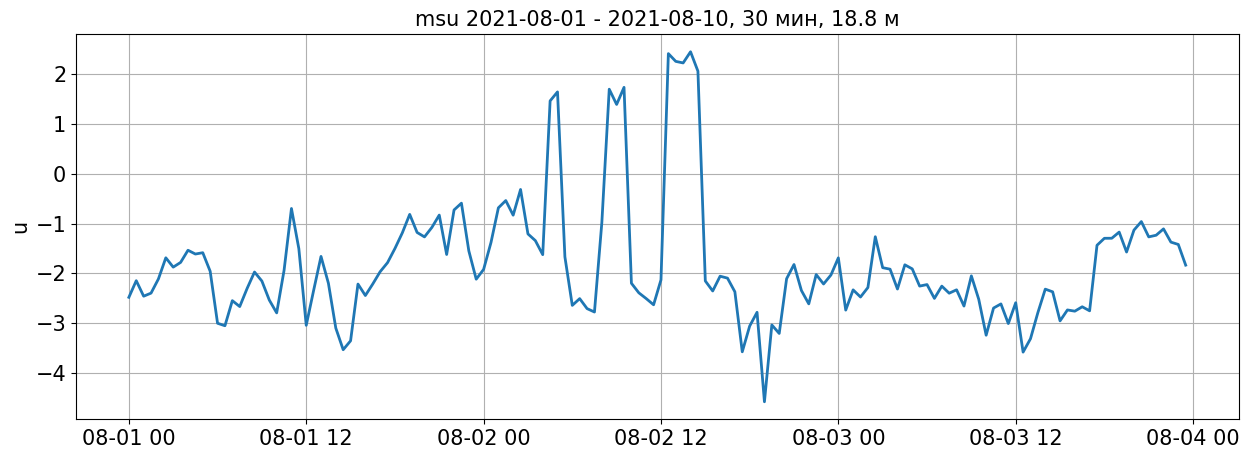

None


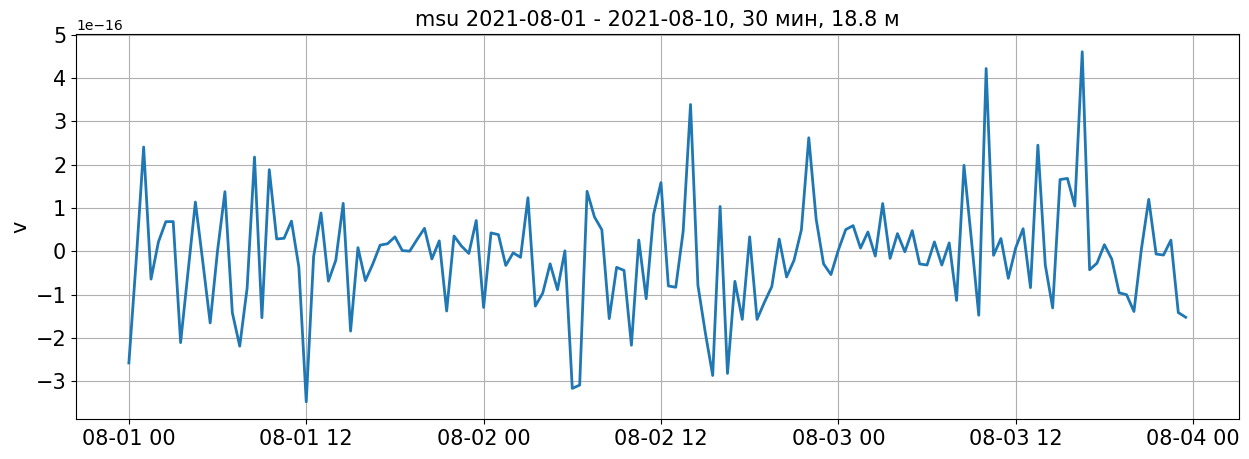

None


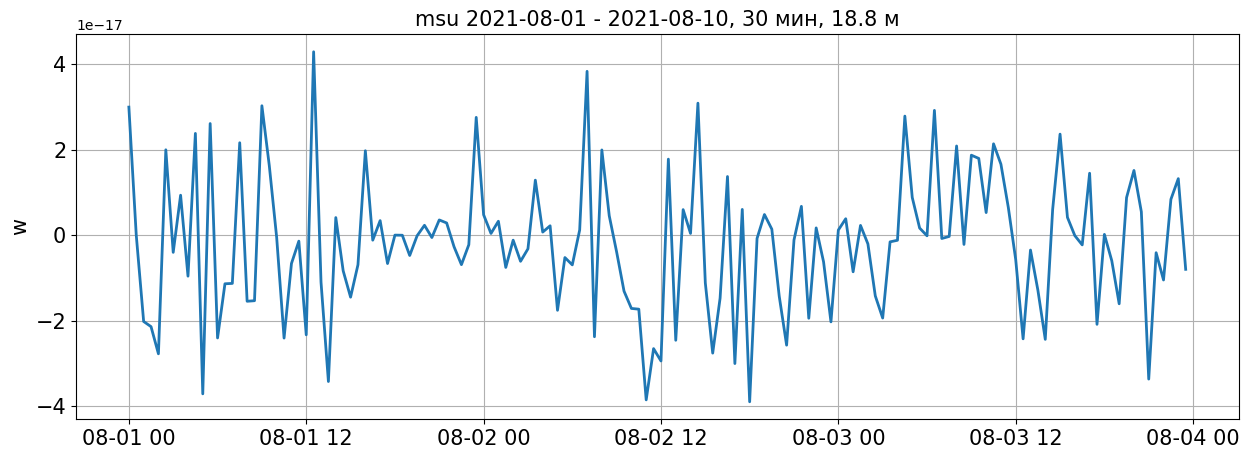

None


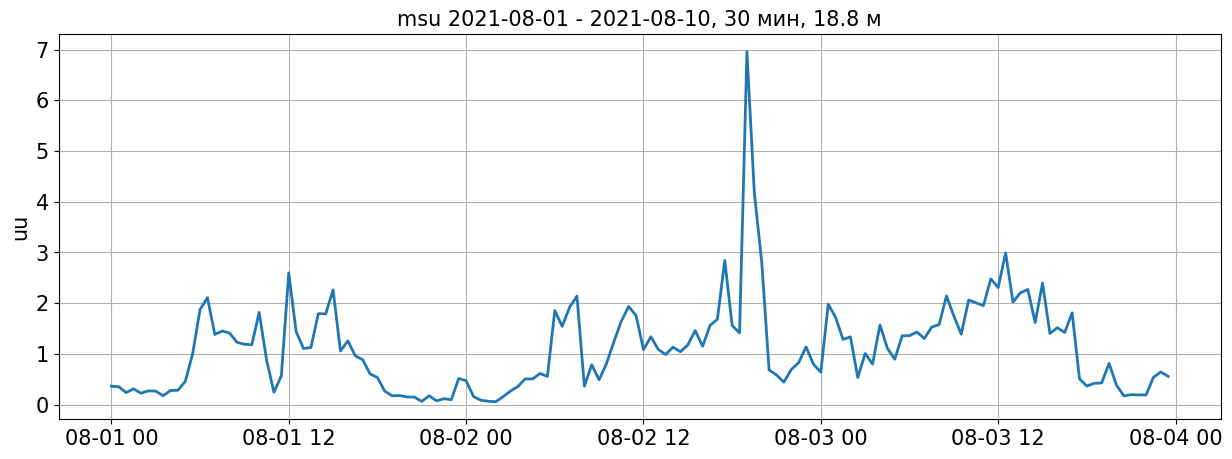

None


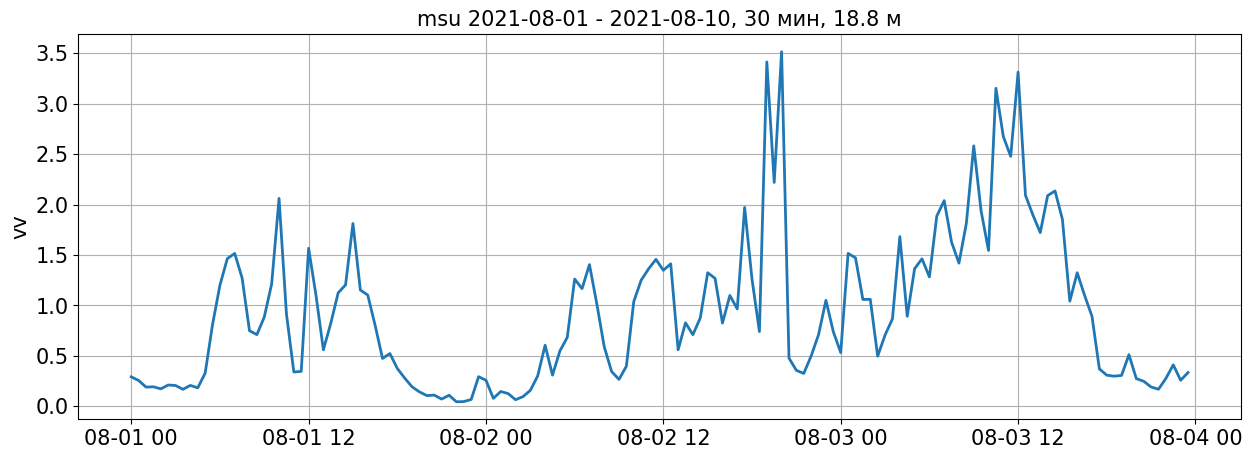

None


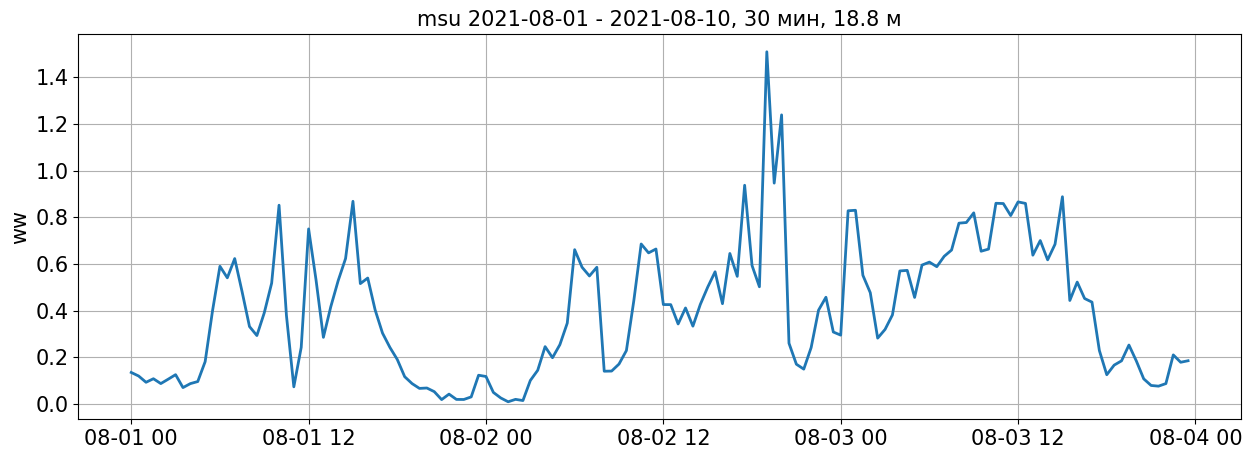

None


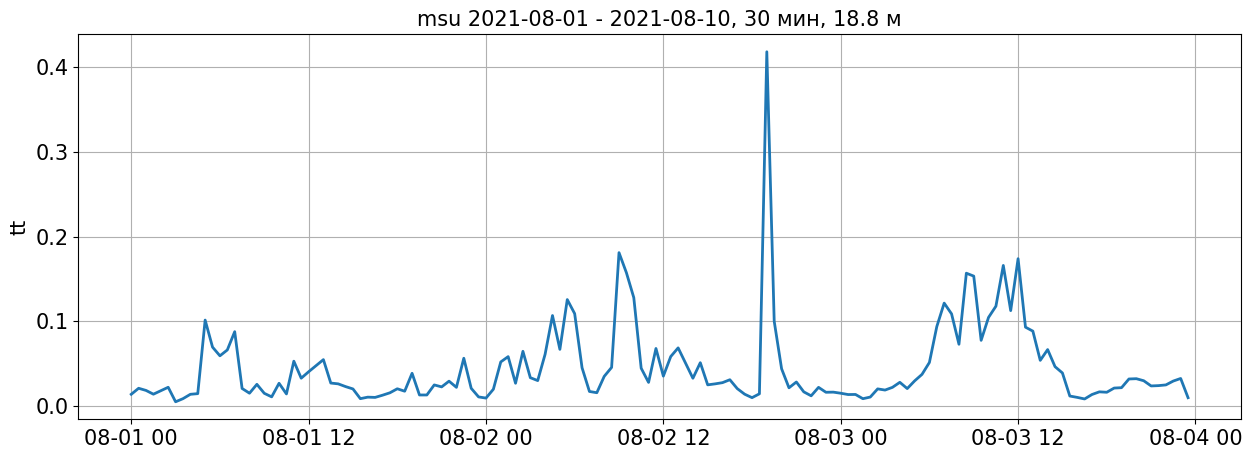

None


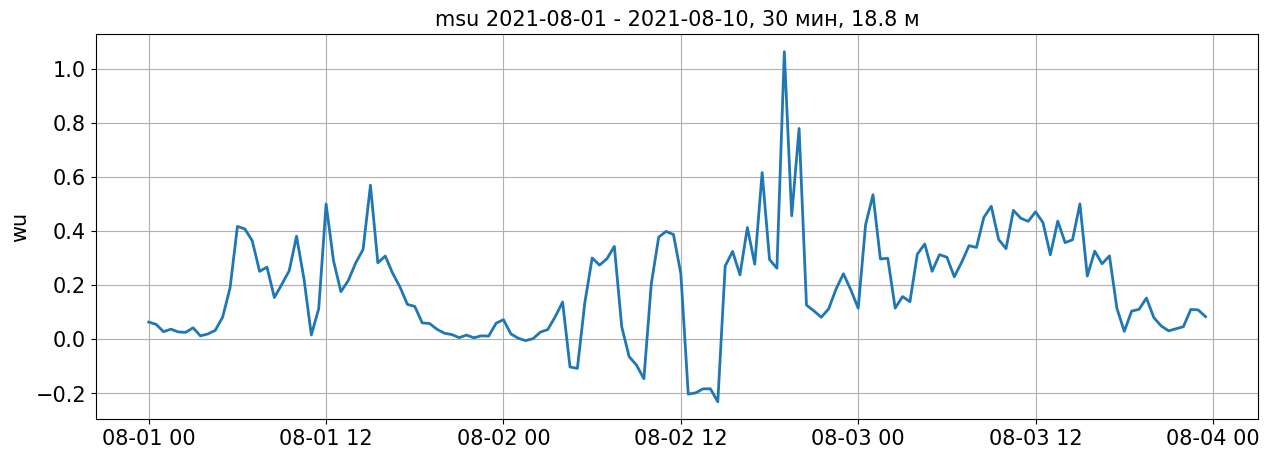

None


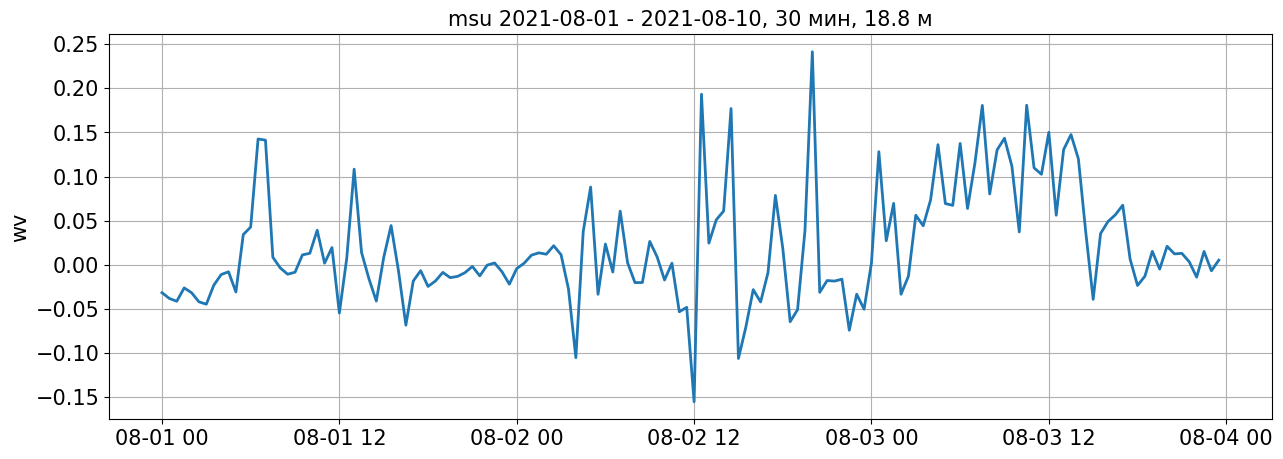

None


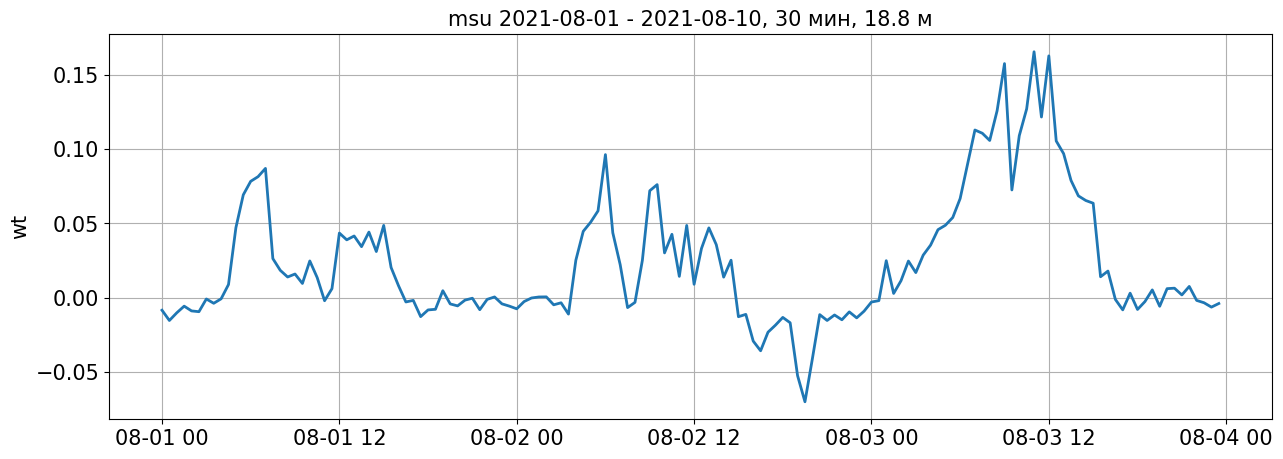

None


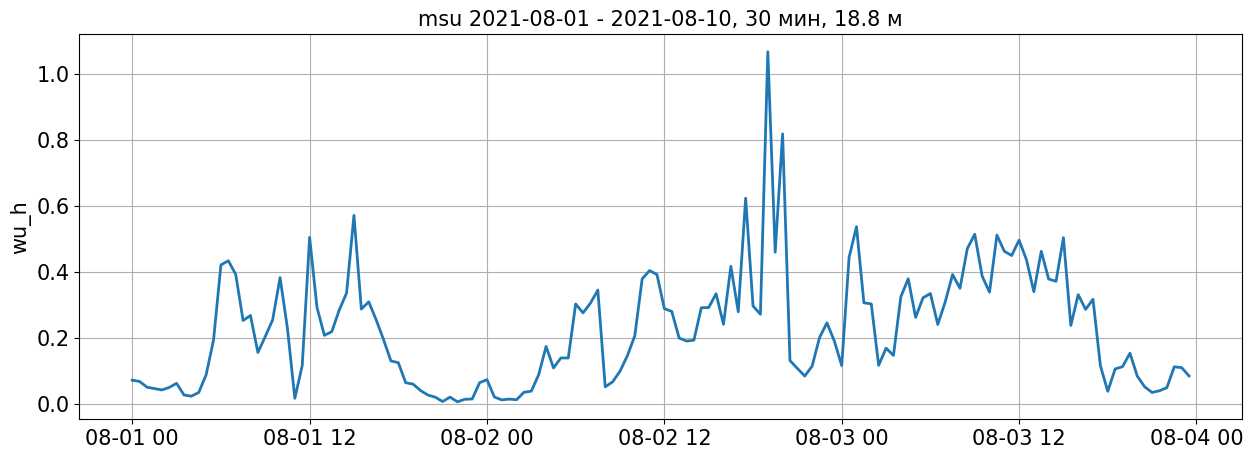

None


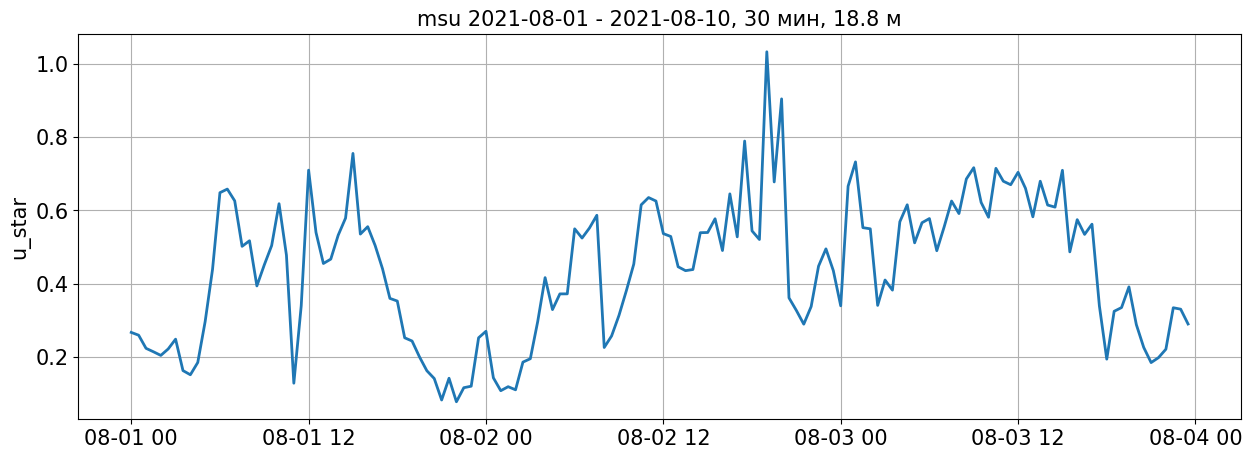

None


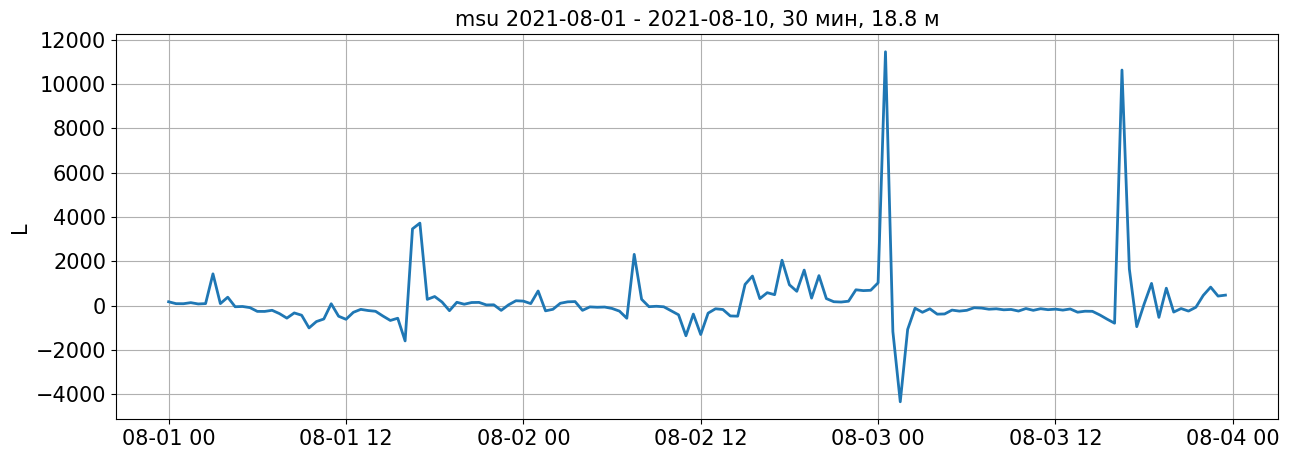

None


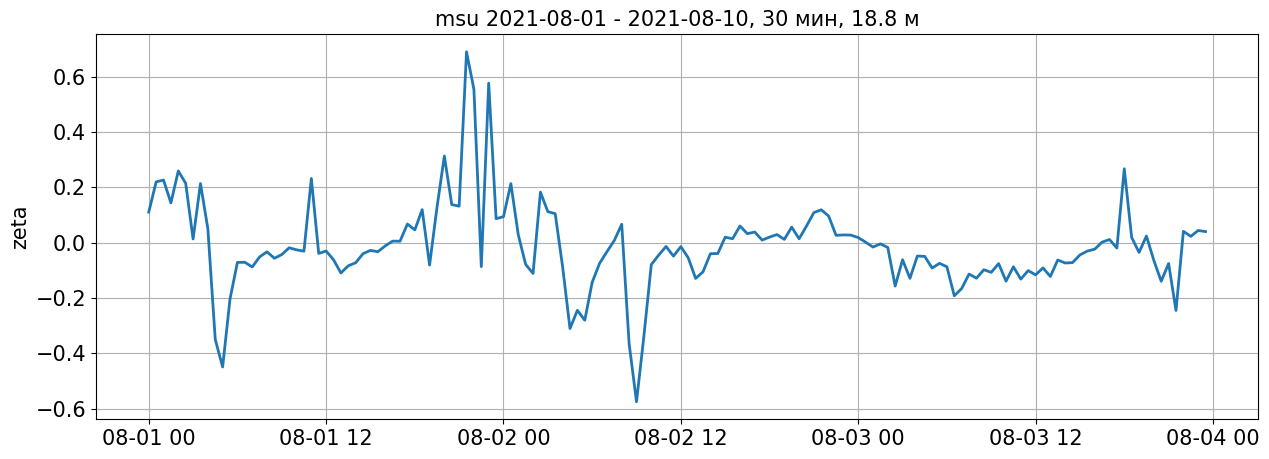

None


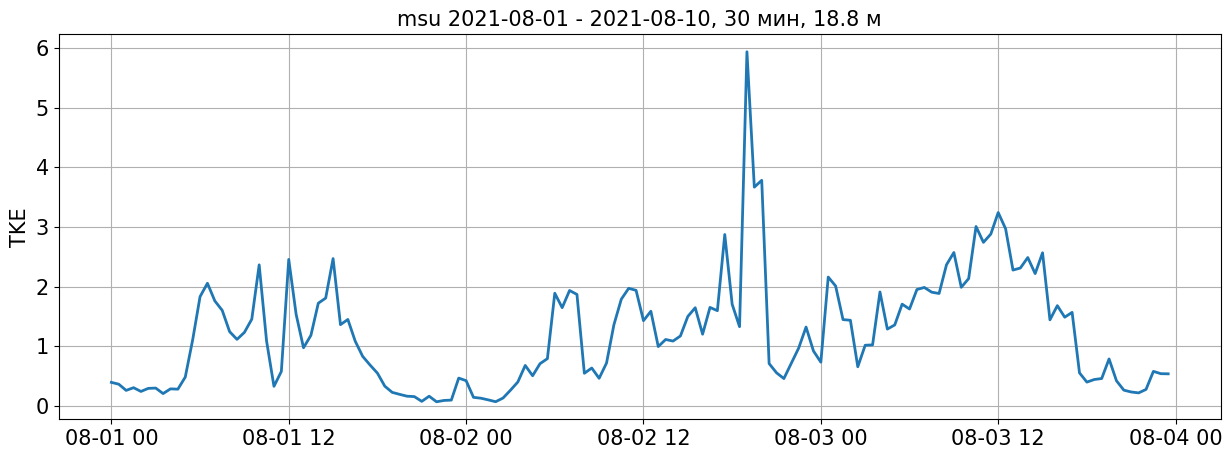

None


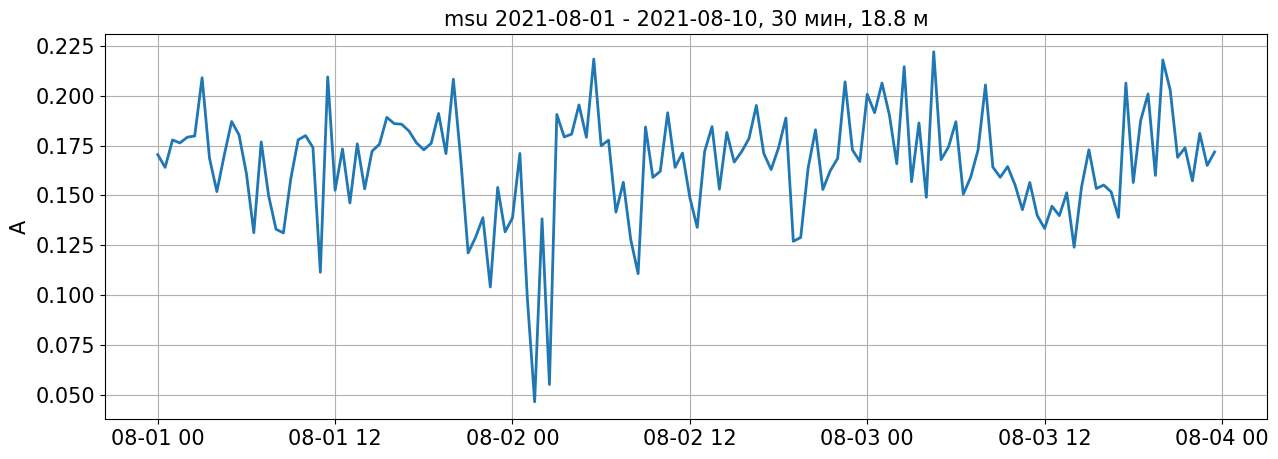

None


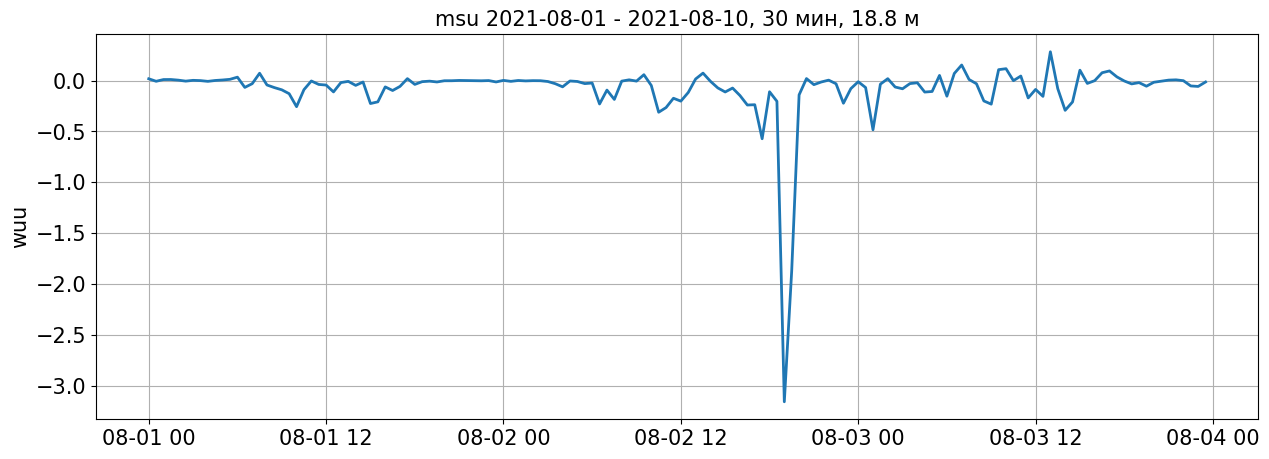

None


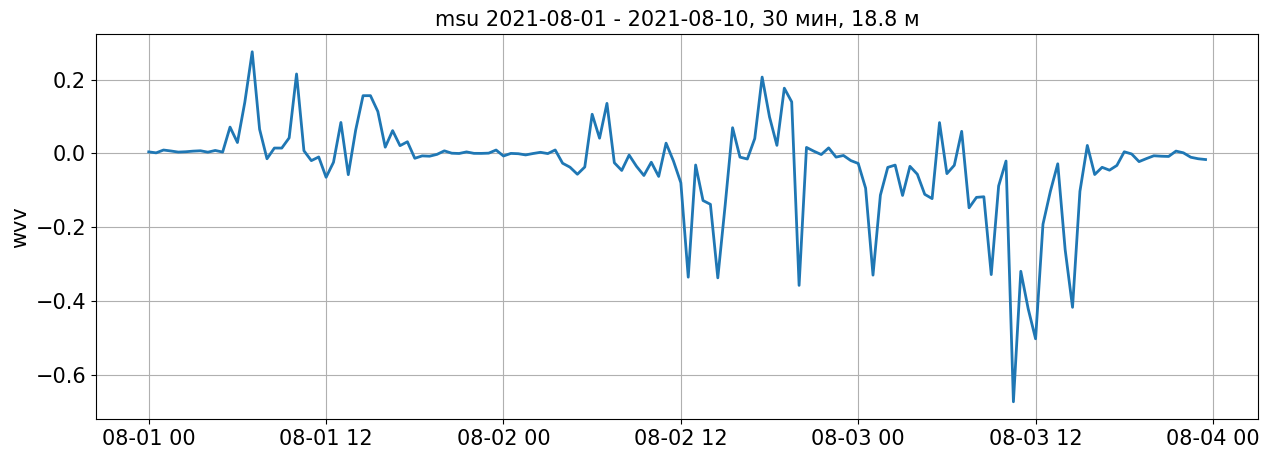

None


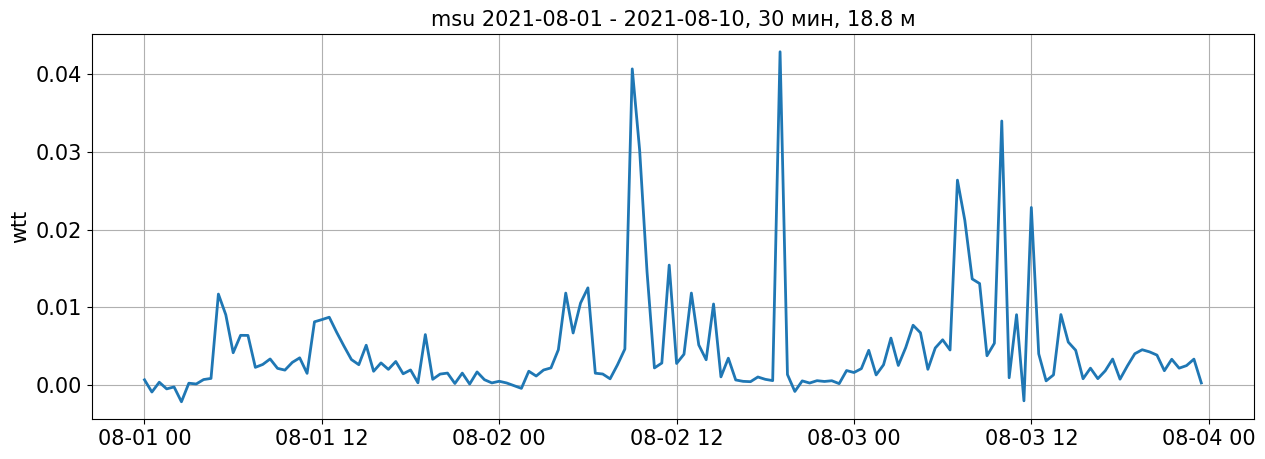

None


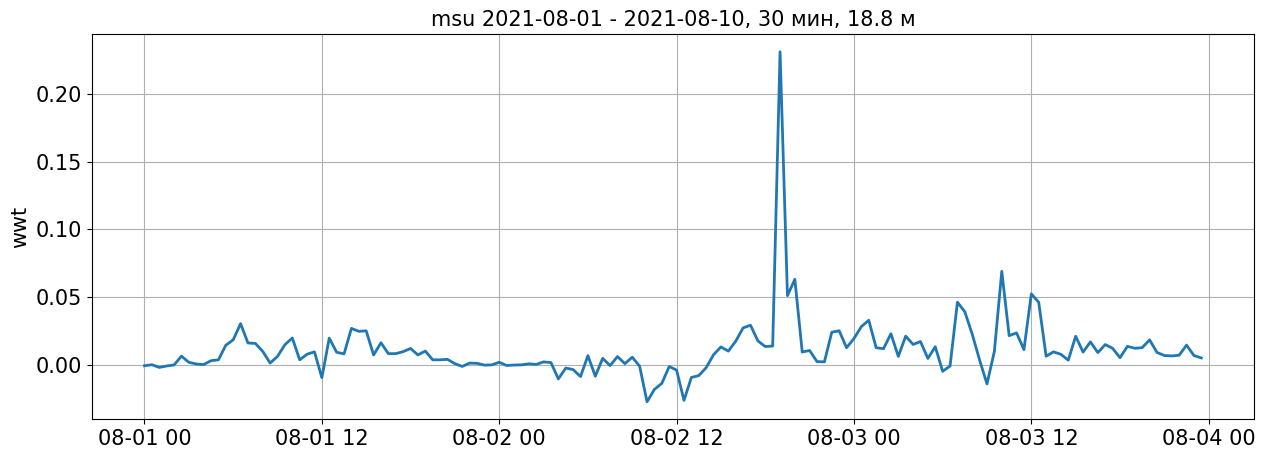

None


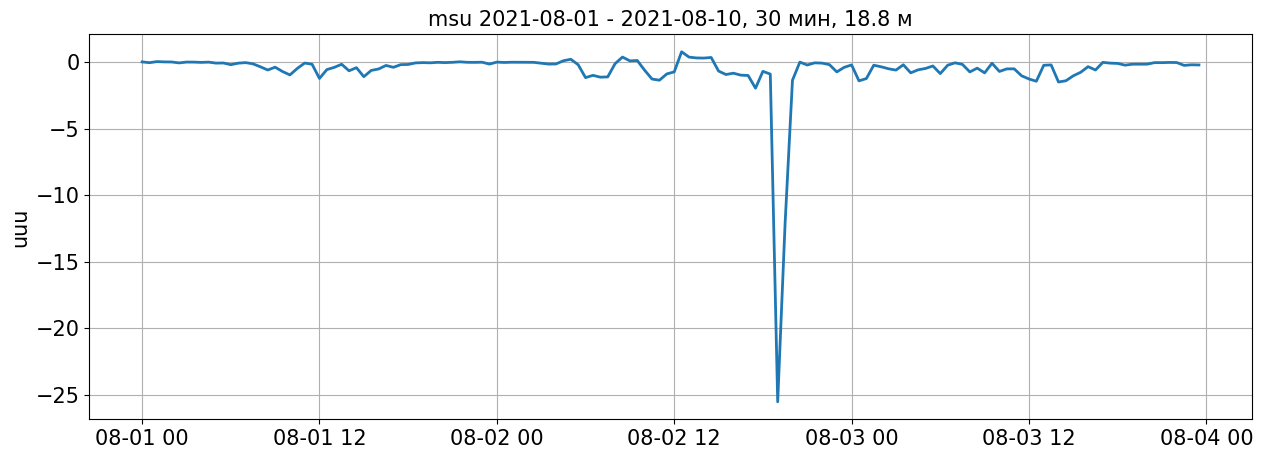

None


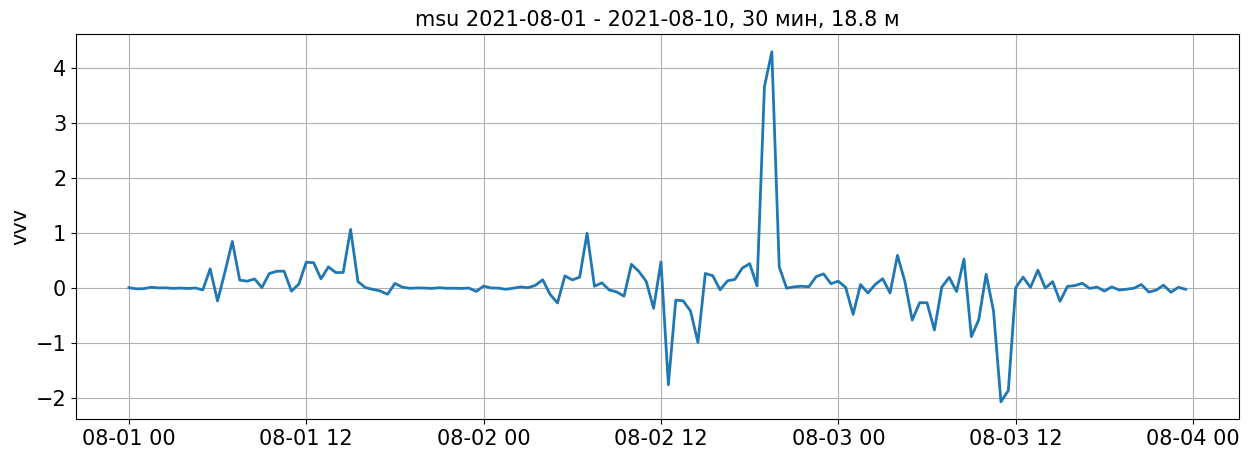

None


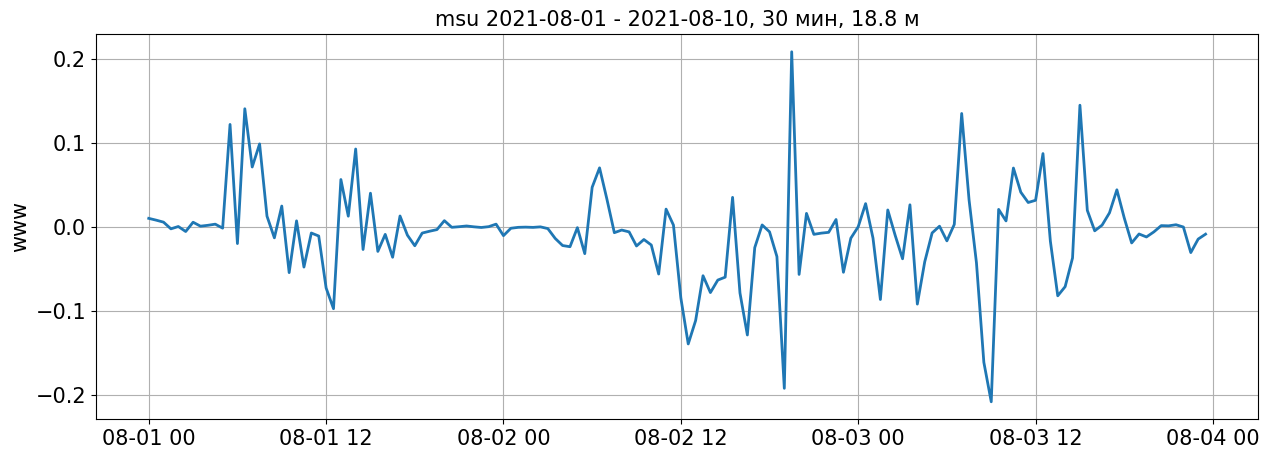

None


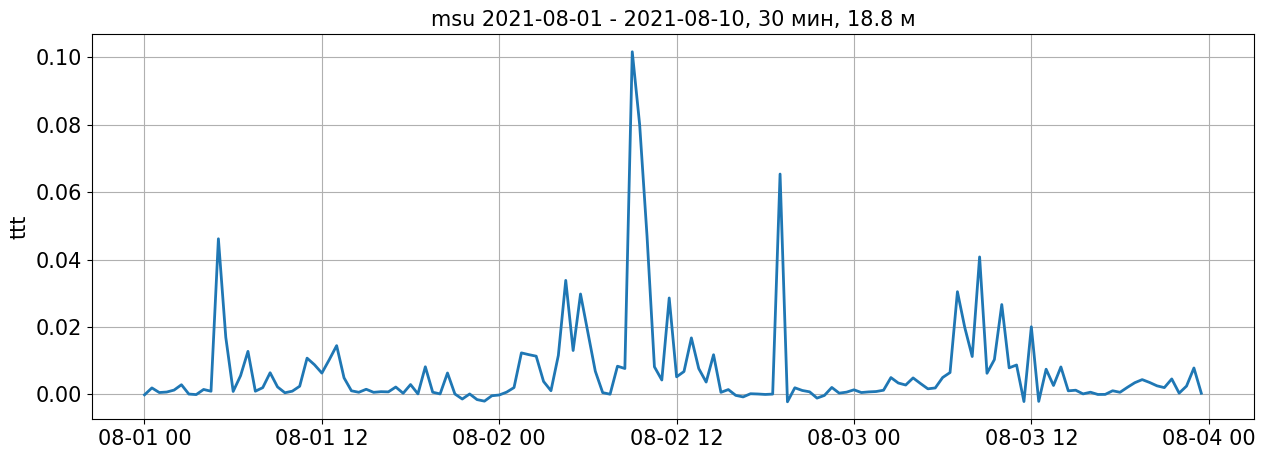

In [40]:
if output_plot:
    for var_name in df1_rot_means:
        title = f'{project_name} {start.date()} - {stop.date()}, {avg_period} мин, {z} м'
        dp.plot_timeseries(df1_rot_means[var_name], ylabel = var_name, title = title,
                          filename = f'{output_path}/output/plots/{start.date()}-{stop.date()}_{var_name}_{avg_period}min.png')
        

## Закрытие логгера

In [ ]:
logger.info('КОНЕЦ ОБРАБОТКИ')
el.close_logger(logger)